# 与学习相关的技巧

## 参数的更新

神经网络的学习的目的是找到使损失函数的值尽可能小的参数。这是寻找最优参数的问题，解决这个问题的过程称为最优化（optimization）。遗憾的是，神经网络的最优化问题非常难。这是因为参数空间非常复杂，无法轻易找到最优解（无法使用那种通过解数学式一下子就求得最小值的方法）。而且，在深度神经网络中，参数的数量非常庞大，导致最优化问题更加复杂。

### SGD

如果将权重矩阵记为$W$，损失函数记为$L$，学习率记为$\eta$，随机梯度下降法的数学表述为：

目标:最小化损失函数$L(W)$，其中 $W$ 是权重矩阵。

随机梯度下降的迭代更新公式为：

$$
W^{(t+1)} = W^{(t)} - \eta \nabla_W L(W),
$$

其中：
* $W^{(t)}$是第$t$次迭代的权重矩阵，
* $\eta$是学习率，
* $\nabla_W L(W)$  是损失函数$L$对权重矩阵$W$的梯度。

对于单样本

如果损失函数是关于一个样本  $(x_i, y_i)$  的，比如：

$$
L(W) = L(f(W, x_i), y_i),
$$

则随机梯度下降的更新规则为：

$$
W^{(t+1)} = W^{(t)} - \eta \nabla_W L(f(W, x_i), y_i),
$$

其中：
* $f(W, x_i)$是模型的预测输出，
* $y_i$是样本的真实标签。

小批量更新

如果使用小批量样本  $\mathcal{B}$，梯度由小批量样本的平均值计算，更新规则为：

$$
W^{(t+1)} = W^{(t)} - \eta \frac{1}{B} \sum_{i \in \mathcal{B}} \nabla_W L(f(W, x_i), y_i),
$$

其中：
* $\mathcal{B}$是当前批次的小批量样本集合，
* $B = |\mathcal{B}|$  是小批量大小。

In [13]:
import numpy as np

class SGD:
    def __init__(self, lr=0.01):
        """
        初始化 SGD 优化器。

        参数:
        lr (float): 学习率。
        """
        self.lr = lr

    def update(self, params, grads):
        """
        使用 SGD 更新参数。

        参数:
        params (dict): 参数字典，键为参数名称，值为参数的当前值。
        grads (dict): 梯度字典，键为参数名称，值为对应参数的梯度。
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]

def predict(params, X):
    """
    预测函数。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。

    返回:
    numpy.ndarray: 预测值。
    """
    return X.dot(params['W']) + params['b']

def compute_loss(params, X, y):
    """
    计算均方误差损失。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。
    y (numpy.ndarray): 真实标签。

    返回:
    float: 均方误差损失。
    """
    m = len(X)
    y_pred = predict(params, X)
    loss = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
    return loss

def compute_gradients(params, X, y):
    """
    计算损失函数相对于参数的梯度。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。
    y (numpy.ndarray): 真实标签。

    返回:
    dict: 梯度字典，包含 'W' 和 'b' 的梯度。
    """
    m = len(X)
    y_pred = predict(params, X)
    error = y_pred - y
    dW = (1 / m) * X.T.dot(error)
    db = (1 / m) * np.sum(error)
    grads = {'W': dW, 'b': db}
    return grads

# 生成合成数据
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # 100 个样本，每个样本有一个特征
y = 4 + 3 * X + np.random.randn(100, 1)  # 线性关系 y = 4 + 3x + 噪声

# 单样本 SGD 测试
params = {
    'W': np.random.randn(1, 1),
    'b': np.random.randn()
}
optimizer = SGD(lr=0.01)
epochs = 50

print("=== 单样本 SGD 测试 ===")
for epoch in range(epochs):
    total_loss = 0
    # 遍历每个样本
    for i in range(len(X)):
        xi = X[i].reshape(1, -1)  # 单个样本特征
        yi = y[i].reshape(1, -1)  # 单个样本标签
        
        # 预测
        y_pred = predict(params, xi)
        
        # 计算损失
        loss = (y_pred - yi) ** 2 / 2
        total_loss += loss.item()
        
        # 计算梯度
        dW = xi.T * (y_pred - yi)
        db = y_pred - yi
        grads = {'W': dW, 'b': db}
        
        # 更新参数
        optimizer.update(params, grads)
    
    average_loss = total_loss / len(X)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

print("最终参数（单样本 SGD）:", params)

# 小批量 SGD 测试
params_mb = {
    'W': np.random.randn(1, 1),
    'b': np.random.randn()
}

# 创建 SGD 优化器实例
optimizer_mb = SGD(lr=0.01)

# 训练参数
epochs = 50
batch_size = 20

print("\n=== 小批量 SGD 测试 ===")

for epoch in range(epochs):
    total_loss = 0
    # 打乱数据顺序
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # 分批处理
    for start_idx in range(0, len(X), batch_size):
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]
        
        # 预测
        y_pred = predict(params_mb, X_batch)
        
        # 计算损失
        loss = (y_pred - y_batch) ** 2 / 2
        total_loss += np.sum(loss)
        
        # 计算梯度
        dW = (1 / len(X_batch)) * X_batch.T.dot(y_pred - y_batch)
        db = (1 / len(X_batch)) * np.sum(y_pred - y_batch)
        grads = {'W': dW, 'b': db}
        
        # 更新参数
        optimizer_mb.update(params_mb, grads)
    
    average_loss = total_loss / len(X)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

print("最终参数（小批量 SGD）:", params_mb)

=== 单样本 SGD 测试 ===
Epoch 10/50, Loss: 0.4115
Epoch 20/50, Loss: 0.4112
Epoch 30/50, Loss: 0.4112
Epoch 40/50, Loss: 0.4112
Epoch 50/50, Loss: 0.4112
最终参数（单样本 SGD）: {'W': array([[2.81706857]]), 'b': array([[4.24065741]])}

=== 小批量 SGD 测试 ===
Epoch 10/50, Loss: 2.0113
Epoch 20/50, Loss: 0.6437
Epoch 30/50, Loss: 0.4681
Epoch 40/50, Loss: 0.4420
Epoch 50/50, Loss: 0.4332
最终参数（小批量 SGD）: {'W': array([[2.37223384]]), 'b': 4.638331372140303}


### SGD的缺点

SGD 的主要缺点包括收敛不稳定、对学习率敏感、容易陷入局部最优、噪声较大、对稀疏数据处理较差以及无法充分利用并行计算资源。不过，通过改进和结合其他优化算法（如 Momentum、AdaGrad、RMSProp、Adam 等），可以克服这些问题，使 SGD 更加高效和鲁棒（更好的泛化能力）。

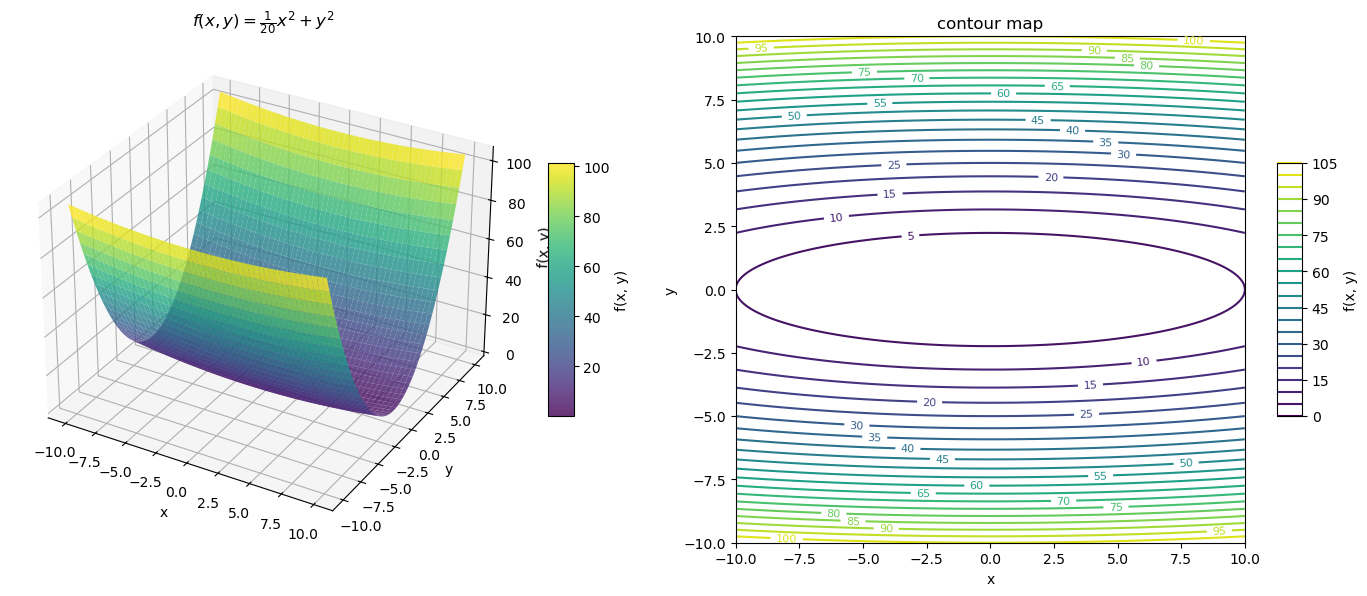

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 定义函数 f(x, y) = (1/20)x^2 + y^2
def f(x, y):
    return (1/20) * x**2 + y**2

# 生成 x 和 y 的值
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# 创建一个图形窗口
fig = plt.figure(figsize=(14, 6))

# 1. 绘制三维表面图
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surface = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_title(r'$f(x, y) = \frac{1}{20}x^2 + y^2$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')
fig.colorbar(surface, ax=ax1, shrink=0.5, aspect=10, label='f(x, y)')

# 2. 绘制等高线图
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(X, Y, Z, levels=20, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_title('contour map')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig.colorbar(contour, ax=ax2, shrink=0.5, aspect=10, label='f(x, y)')

# 调整布局并显示图形
plt.tight_layout()
plt.show()

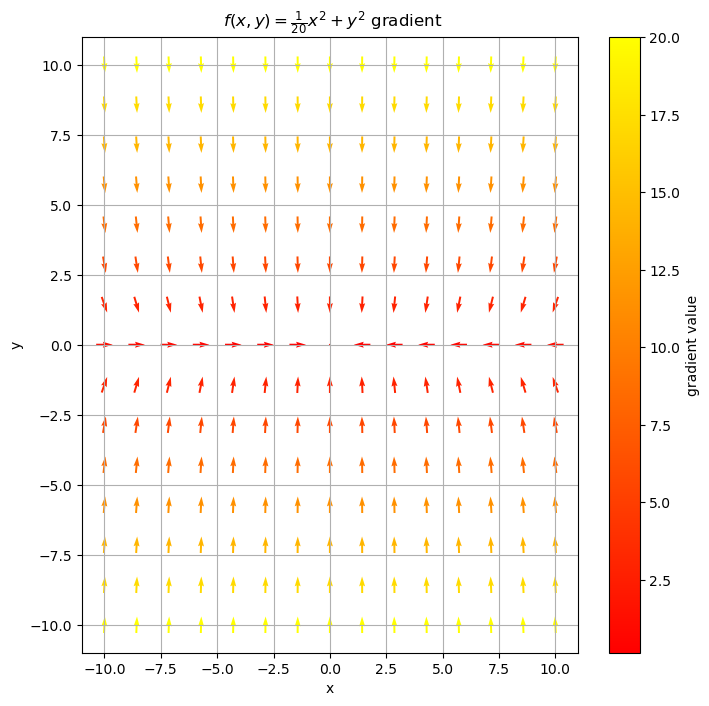

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数 f(x, y) = (1/20)x^2 + y^2
def f(x, y):
    return (1/20) * x**2 + y**2

# 定义负梯度函数 -∇f(x, y) = (-df/dx, -df/dy) = (-1/10 x, -2y)
def negative_gradient_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return -df_dx, -df_dy

# 生成 x 和 y 的值
x = np.linspace(-10, 10, 15)  # 调整网格点数量
y = np.linspace(-10, 10, 15)
X, Y = np.meshgrid(x, y)
U, V = negative_gradient_f(X, Y)

# 计算梯度向量的长度，用于归一化箭头长度 欧几里得范数（Euclidean norm）
M = np.hypot(U, V)
M[M == 0] = 1  # 避免除以零
U_normalized = U / M
V_normalized = V / M

# 创建图形
plt.figure(figsize=(8, 8))

# 绘制梯度向量
plt.quiver(X, Y, U_normalized, V_normalized, M, pivot='middle', cmap='autumn', scale=30, headwidth=3)

# 设置标题和标签
plt.title(r' $f(x, y) = \frac{1}{20}x^2 + y^2$ gradient')
plt.xlabel('x')
plt.ylabel('y')

# 设置坐标轴范围
plt.xlim(-11, 11)
plt.ylim(-11, 11)

# 添加颜色条，表示梯度向量的大小
plt.colorbar(label='gradient value')

# 添加网格
plt.grid(True)

# 显示图形
plt.show()

这个梯度的特征是，y轴方向上大，x轴方向上小。换句话说，就是y轴方向的坡度大，而x轴方向的坡度小。这里需要注意的是，虽然最小值在$(x, y) = (0, 0)$处，但是图6-2中的梯度在很多地方并没有指向$(0, 0)$。

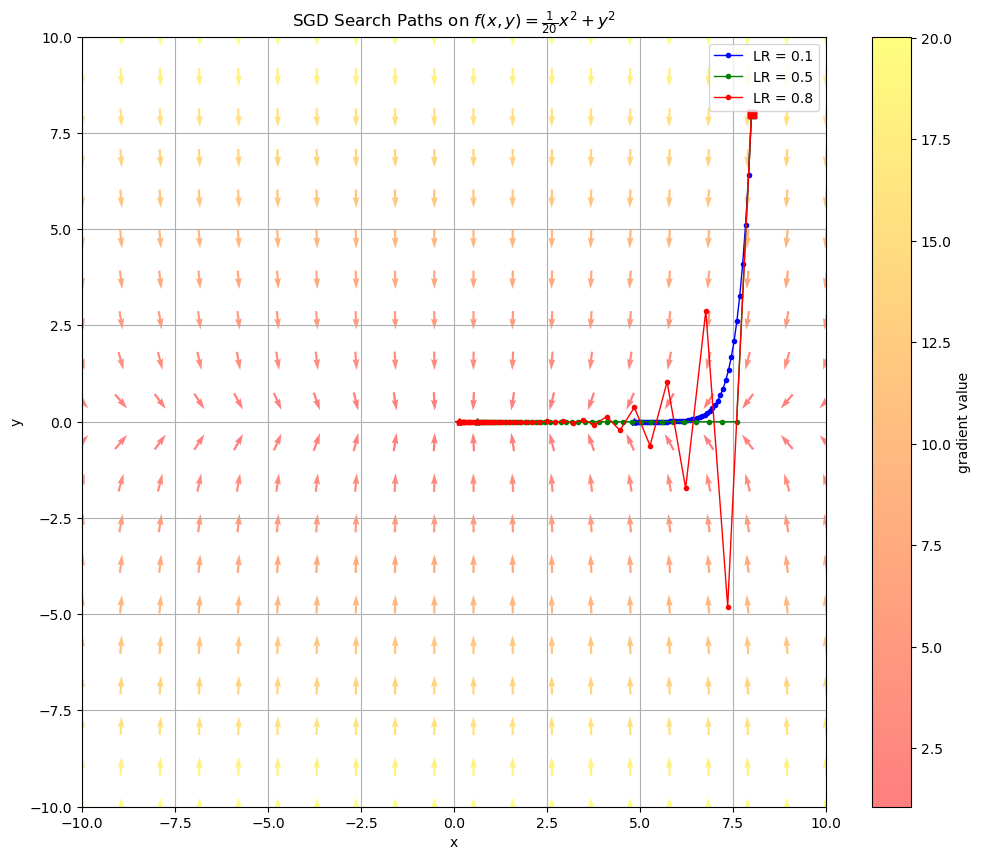

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 定义目标函数 f(x, y) = (1/20)x^2 + y^2
def f(x, y):
    return (1/20) * x**2 + y**2

# 定义梯度函数 ∇f(x, y) = (1/10 x, 2y)
def gradient_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# 定义SGD优化器
class SGD:
    def __init__(self, lr=0.01):
        """
        初始化SGD优化器。
        
        参数:
        lr (float): 学习率。
        """
        self.lr = lr

    def update(self, params, grads):
        """
        使用SGD更新参数。
        
        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。
        
        返回:
        np.ndarray: 更新后的参数向量。
        """
        return params - self.lr * grads

# 定义函数来执行SGD并记录路径
def run_sgd(initial_params, learning_rate, epochs):
    """
    执行SGD优化并记录参数更新路径。
    
    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    epochs (int): 迭代次数。
    
    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = SGD(lr=learning_rate)
    params = initial_params.copy()
    path = [params.copy()]
    
    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())
    
    return np.array(path)

# 生成绘图网格
x = np.linspace(-10, 10, 20)  # 较少的点以避免箭头过于密集
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)
U, V = gradient_f(X, Y)
# 计算负梯度，用于绘制梯度场指向下降方向
U_neg, V_neg = -U, -V
# 归一化梯度向量以控制箭头长度
M = np.hypot(U_neg, V_neg)
M[M == 0] = 1  # 避免除以零
U_normalized = U_neg / M
V_normalized = V_neg / M

# 定义不同的学习率
learning_rates = [0.1, 0.5, 0.8]
colors = ['blue', 'green', 'red']
labels = [f'LR = {lr}' for lr in learning_rates]

# 初始化图形
plt.figure(figsize=(12, 10))

# 绘制梯度场
plt.quiver(X, Y, U_normalized, V_normalized, M, pivot='middle', cmap='autumn', alpha=0.5, scale=40)
plt.colorbar(label='gradient value')

# 初始参数
initial_params = np.array([8.0, 8.0])

# 记录并绘制每个学习率的SGD路径
for lr, color, label in zip(learning_rates, colors, labels):
    path = run_sgd(initial_params, lr, epochs=50)
    plt.plot(path[:, 0], path[:, 1], marker='o', color=color, label=label, markersize=3, linewidth=1)

    # 可选：标记路径的起点和终点
    plt.plot(path[0, 0], path[0, 1], marker='s', color=color, markersize=6)  # 起点
    plt.plot(path[-1, 0], path[-1, 1], marker='*', color=color, markersize=6)  # 终点

# 设置标题和标签
plt.title(r'SGD Search Paths on $f(x, y) = \frac{1}{20}x^2 + y^2$')
plt.xlabel('x')
plt.ylabel('y')

# 设置坐标轴范围
plt.xlim(-10, 10)
plt.ylim(-10, 10)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True)

# 显示图形
plt.show()

学习率的选择：学习率的大小直接影响SGD的更新步伐和路径形状：
* 较大的学习率：可能导致更新步伐过大，甚至使参数在最小值附近振荡 $\eta = 0.8$。
* 适中的学习率：可以确保更新步伐适中，平滑地朝向最小值移动 $\eta = 0.1$。
* 较小的学习率：更新步伐较小，可能需要更多的迭代次数才能收敛。

### 动量优化算法

动量（Momentum）是一种在梯度下降优化算法中引入“惯性”概念的方法，通过积累之前梯度的指数加权平均，帮助加速收敛并减少振荡。

动量优化算法通过引入一个“速度”向量$v$，该向量是梯度的指数加权平均，来更新参数。这样可以在梯度方向上加速，同时在噪声较大的梯度方向上减少振荡。

主要参数
* $W$ ：神经网络的权重矩阵。
* $L(W)$ ：损失函数，通常是关于训练数据的损失。
* $\eta$ ：学习率（Learning Rate），控制更新步伐的大小。
* $\beta$ ：动量系数（Momentum Coefficient），通常取值在0.9左右，决定了过去梯度对当前速度的影响程度。
* $v$ ：速度向量，用于存储累积的梯度信息。

<span style="color: red;">**单样本场景下的动量SGD-Momentum**</span>

更新步骤

1. 计算当前梯度：

$$
g^{(t)} = \nabla_W L(W^{(t)}, x_i, y_i)
$$

2. 更新速度向量：

$$
v^{(t+1)} = \beta v^{(t)} + (1 - \beta) g^{(t)}
$$

3. 更新权重：

$$
W^{(t+1)} = W^{(t)} - \eta v^{(t+1)}
$$

公式解释

* 速度向量更新：

$$
v^{(t+1)} = \beta v^{(t)} + (1 - \beta) g^{(t)}
$$

这里， $\beta v^{(t)}$  是过去速度的保留部分， $(1 - \beta) g^{(t)}$  是当前梯度的贡献。动量系数$\beta$控制了过去梯度对当前速度的影响程度。

* 权重更新：

$$
W^{(t+1)} = W^{(t)} - \eta v^{(t+1)}
$$

权重向量沿着速度向量的方向更新，步伐由学习率$\eta$控制。

<span style="color: red;">**小批量场景下的动量Mini-batch SGD-Momentum**</span>

在小批量场景下，每次迭代使用一个小批量样本$\mathcal{B}$来计算梯度并更新权重。

更新步骤

1. 计算当前梯度：

$$
g^{(t)} = \nabla_W L(W^{(t)}, \mathcal{B})
$$

其中， $L(W^{(t)}, \mathcal{B}) = \frac{1}{|\mathcal{B}|} \sum_{(x_i, y_i) \in \mathcal{B}} L(W^{(t)}, x_i, y_i) $。

2. 更新速度向量：

$$
v^{(t+1)} = \beta v^{(t)} + (1 - \beta) g^{(t)}
$$

3. 更新权重：

$$
W^{(t+1)} = W^{(t)} - \eta v^{(t+1)}
$$

公式解释

* 梯度计算：
在小批量场景下，梯度$g^{(t)}$是对小批量样本的平均梯度，减少了梯度估计的方差，使得更新更加稳定。

* 速度向量和权重更新：
与单样本场景相同，速度向量结合了过去的速度和当前的平均梯度，权重沿着速度向量方向更新。


In [68]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Momentum 优化器
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        """
        初始化 Momentum 优化器。

        参数:
        lr (float): 学习率。
        momentum (float): 动量系数。
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        """
        使用 Momentum 更新参数。

        参数:
        params (dict): 参数字典，键为参数名称，值为参数的当前值。
        grads (dict): 梯度字典，键为参数名称，值为对应参数的梯度。
        """
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

def predict(params, X):
    """
    预测函数。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。

    返回:
    numpy.ndarray: 预测值。
    """
    return X.dot(params['W']) + params['b']

def compute_loss(params, X, y):
    """
    计算均方误差损失。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。
    y (numpy.ndarray): 真实标签。

    返回:
    float: 均方误差损失。
    """
    m = len(X)
    y_pred = predict(params, X)
    loss = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
    return loss

def compute_gradients(params, X, y):
    """
    计算损失函数相对于参数的梯度。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。
    y (numpy.ndarray): 真实标签。

    返回:
    dict: 梯度字典，包含 'W' 和 'b' 的梯度。
    """
    m = len(X)
    y_pred = predict(params, X)
    error = y_pred - y
    dW = (1 / m) * X.T.dot(error)
    db = (1 / m) * np.sum(error)
    grads = {'W': dW, 'b': db}
    return grads

# 生成合成数据
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # 100 个样本，每个样本有一个特征
y = 4 + 3 * X + np.random.randn(100, 1)  # 线性关系 y = 4 + 3x + 噪声

# 单样本 Momentum 测试
momentum_optimizer = Momentum(lr=0.01, momentum=0.9)
epochs = 50

# 初始化参数
params = {
    'W': np.random.randn(1, 1),
    'b': np.random.randn()
}

print("=== 单样本 Momentum 测试 ===")
for epoch in range(epochs):
    total_loss = 0
    # 遍历每个样本
    for i in range(len(X)):
        xi = X[i].reshape(1, -1)  # 单个样本特征
        yi = y[i].reshape(1, -1)  # 单个样本标签

        # 预测
        y_pred = predict(params, xi)

        # 计算损失
        loss = (y_pred - yi) ** 2 / 2
        total_loss += loss.item()

        # 计算梯度
        dW = xi.T * (y_pred - yi)
        db = y_pred - yi
        grads = {'W': dW, 'b': db}

        # 更新参数
        momentum_optimizer.update(params, grads)

    average_loss = total_loss / len(X)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

print("最终参数（单样本 Momentum）:", params)

# 小批量 Momentum 测试
momentum_optimizer_mb = Momentum(lr=0.01, momentum=0.9)
epochs = 50
batch_size = 20

# 初始化参数
params_mb = {
    'W': np.random.randn(1, 1),
    'b': np.random.randn()
}

print("\n=== 小批量 Momentum 测试 ===")

for epoch in range(epochs):
    total_loss = 0
    # 打乱数据顺序
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # 分批处理
    for start_idx in range(0, len(X), batch_size):
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]

        # 预测
        y_pred = predict(params_mb, X_batch)

        # 计算损失
        loss = (y_pred - y_batch) ** 2 / 2
        total_loss += np.sum(loss)

        # 计算梯度
        dW = (1 / len(X_batch)) * X_batch.T.dot(y_pred - y_batch)
        db = (1 / len(X_batch)) * np.sum(y_pred - y_batch)
        grads = {'W': dW, 'b': db}

        # 更新参数
        momentum_optimizer_mb.update(params_mb, grads)

    average_loss = total_loss / len(X)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

print("最终参数（小批量 Momentum）:", params_mb)

=== 单样本 Momentum 测试 ===
Epoch 10/50, Loss: 0.4402
Epoch 20/50, Loss: 0.4402
Epoch 30/50, Loss: 0.4402
Epoch 40/50, Loss: 0.4402
Epoch 50/50, Loss: 0.4402
最终参数（单样本 Momentum）: {'W': array([[3.01518164]]), 'b': array([[4.19206074]])}

=== 小批量 Momentum 测试 ===
Epoch 10/50, Loss: 0.4984
Epoch 20/50, Loss: 0.4066
Epoch 30/50, Loss: 0.4049
Epoch 40/50, Loss: 0.4042
Epoch 50/50, Loss: 0.4040
最终参数（小批量 Momentum）: {'W': array([[2.76792354]]), 'b': 4.217113416091627}


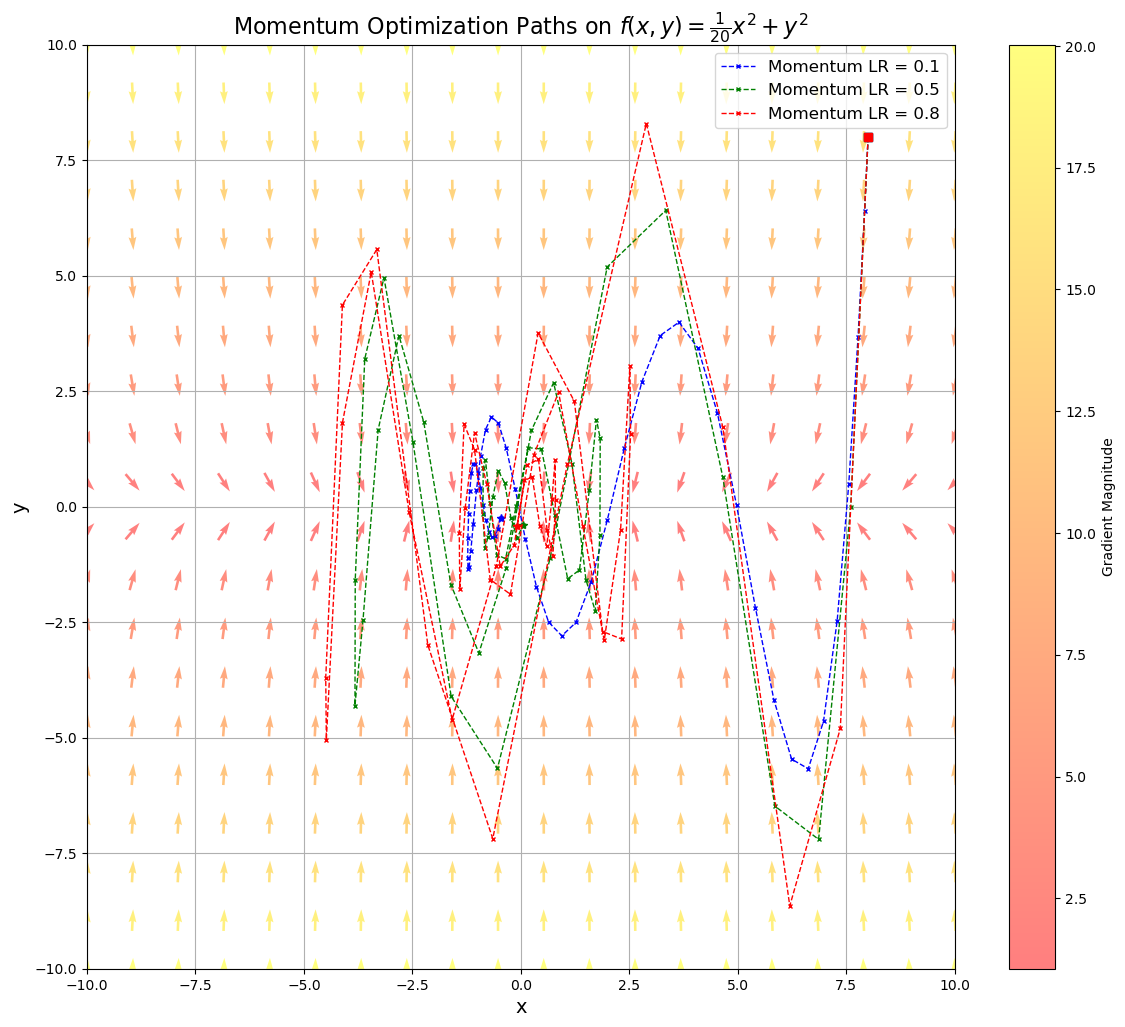

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# 定义目标函数 f(x, y) = (1/20)x^2 + y^2
def f(x, y):
    return (1/20) * x**2 + y**2

# 定义梯度函数 ∇f(x, y) = (1/10 x, 2y)
def gradient_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# 定义SGD优化器
class SGD:
    def __init__(self, lr=0.01):
        """
        初始化SGD优化器。

        参数:
        lr (float): 学习率。
        """
        self.lr = lr

    def update(self, params, grads):
        """
        使用SGD更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        return params - self.lr * grads

# 定义Momentum优化器
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        """
        初始化 Momentum 优化器。

        参数:
        lr (float): 学习率。
        momentum (float): 动量系数。
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None  # 速度向量

    def update(self, params, grads):
        """
        使用 Momentum 更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        if self.v is None:
            self.v = np.zeros_like(params)

        self.v = self.momentum * self.v - self.lr * grads
        params = params + self.v
        return params

# 定义函数来执行SGD并记录路径
def run_sgd(initial_params, learning_rate, epochs):
    """
    执行SGD优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    epochs (int): 迭代次数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = SGD(lr=learning_rate)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 定义函数来执行Momentum并记录路径
def run_momentum(initial_params, learning_rate, momentum_coeff, epochs):
    """
    执行Momentum优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    momentum_coeff (float): 动量系数。
    epochs (int): 迭代次数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = Momentum(lr=learning_rate, momentum=momentum_coeff)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 生成绘图网格
x = np.linspace(-10, 10, 20)  # 较少的点以避免箭头过于密集
y = np.linspace(-10, 10, 20)
X_grid, Y_grid = np.meshgrid(x, y)
U, V = gradient_f(X_grid, Y_grid)
# 计算负梯度，用于绘制梯度场指向下降方向
U_neg, V_neg = -U, -V
# 归一化梯度向量以控制箭头长度
M = np.hypot(U_neg, V_neg)
M[M == 0] = 1  # 避免除以零
U_normalized = U_neg / M
V_normalized = V_neg / M

# 定义不同的学习率
learning_rates = [0.1, 0.5, 0.8]
colors = ['blue', 'green', 'red']
labels = [f'LR = {lr}' for lr in learning_rates]

# 初始化图形
plt.figure(figsize=(14, 12))

# 绘制梯度场
plt.quiver(X_grid, Y_grid, U_normalized, V_normalized, M, pivot='middle', cmap='autumn', alpha=0.5, scale=40)
plt.colorbar(label='Gradient Magnitude')

# 初始参数
initial_params = np.array([8.0, 8.0])

# 记录并绘制每个学习率的SGD和Momentum路径
for lr, color, label in zip(learning_rates, colors, labels):
    # 运行Momentum
    momentum_path = run_momentum(initial_params, lr, momentum_coeff=0.9, epochs=50)
    plt.plot(momentum_path[:, 0], momentum_path[:, 1], marker='x', color=color, linestyle='--', label=f'Momentum {label}', markersize=3, linewidth=1)
    plt.plot(momentum_path[0, 0], momentum_path[0, 1], marker='s', color=color, markersize=6)  # 起点
    plt.plot(momentum_path[-1, 0], momentum_path[-1, 1], marker='*', color=color, markersize=6)  # 终点

# 设置标题和标签
plt.title(r'Momentum Optimization Paths on $f(x, y) = \frac{1}{20}x^2 + y^2$', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

# 设置坐标轴范围
plt.xlim(-10, 10)
plt.ylim(-10, 10)

# 添加图例
plt.legend(loc='upper right', fontsize=12)

# 添加网格
plt.grid(True)

# 显示图形
plt.show()

和SGD相比，我们发现 “之”字形的“程度”减轻了。这是因为虽然x轴方向上受到的力非常小，但是一直在同一方向上受力，所以朝同一个方向会有一定的加速。反过来，虽然y轴方向上受到的力很大，但是因为交互地受到正方向和反方向的力，它们会互相抵消，所以y轴方向上的速度不稳定。因此，和SGD时的情形相比， 可以更快地朝x轴方向靠近，减弱“之”字形的变动程度。

### Adam

Adam（Adaptive Moment Estimation）是一种广泛使用的优化算法，它结合了动量（Momentum）和RMSProp的优点，通过自适应调整每个参数的学习率，提升了优化过程的效率和稳定性。

Adam优化算法结合了动量和自适应学习率的方法，通过计算梯度的一阶矩（均值）和二阶矩（未中心化的方差）的指数加权平均，动态调整每个参数的学习率。其主要步骤包括：

1. 计算梯度：计算当前参数的梯度。
2. 更新一阶矩向量（动量）：累积梯度的指数加权平均。
3. 更新二阶矩向量（均方根）：累积梯度平方的指数加权平均。
4. 偏差修正：由于一阶矩和二阶矩在初始阶段被初始化为零，进行偏差修正以获得更准确的估计。
5. 更新参数：使用修正后的矩阵更新参数。

设参数向量为$W$，在第$t$次迭代时，Adam算法的更新步骤如下：

<span style="color: red;">**参数和超参数**</span>

* 参数向量：$W^{(t)}$表示第$t$次迭代时的参数。
* 学习率：$\eta$。
* 一阶矩衰减率：$\beta_1$ （通常设置为  0.9 ）。
* 二阶矩衰减率：$\beta_2$（通常设置为  0.999 ）。
* 小常数：$\epsilon$ （例如  $10^{-8}$ ），用于数值稳定性。

<span style="color: red;">**单样本场景下的Adam**</span> 

在单样本（Stochastic）场景下，每次迭代使用一个样本$(x_i, y_i)$来计算梯度并更新参数。

更新步骤

1. 计算梯度：

$$
g^{(t)} = \nabla_W L(W^{(t)}, x_i, y_i)
$$

其中， $L(W^{(t)}, x_i, y_i)$是当前样本的损失函数。

2. 更新一阶矩向量（动量）：

$$
m^{(t)} = \beta_1 m^{(t-1)} + (1 - \beta_1) g^{(t)}
$$

3. 更新二阶矩向量（均方根）：

$$
v^{(t)} = \beta_2 v^{(t-1)} + (1 - \beta_2) \left( g^{(t)} \right)^2
$$

4. 偏差修正：

$$
\hat{m}^{(t)} = \frac{m^{(t)}}{1 - \beta_1^t}
$$

$$
\hat{v}^{(t)} = \frac{v^{(t)}}{1 - \beta_2^t}
$$

5. 更新参数：

$$
W^{(t+1)} = W^{(t)} - \eta \frac{\hat{m}^{(t)}}{\sqrt{\hat{v}^{(t)}} + \epsilon}
$$

**总结**

$$
g^{(t)} = \nabla_W L(W^{(t)}, x_i, y_i) 
$$

$$
m^{(t)} = \beta_1 m^{(t-1)} + (1 - \beta_1) g^{(t)} 
$$

$$
v^{(t)} = \beta_2 v^{(t-1)} + (1 - \beta_2) \left( g^{(t)} \right)^2 
$$

$$
\hat{m}^{(t)} = \frac{m^{(t)}}{1 - \beta_1^t} 
$$

$$
\hat{v}^{(t)} = \frac{v^{(t)}}{1 - \beta_2^t} 
$$

$$
W^{(t+1)} = W^{(t)} - \eta \frac{\hat{m}^{(t)}}{\sqrt{\hat{v}^{(t)}} + \epsilon}
$$

<span style="color: red;">**小批量场景下的Adam**</span> 

在小批量（Mini-batch）场景下，每次迭代使用一个小批量样本$\mathcal{B}$来计算梯度并更新参数。

更新步骤

1. 计算当前梯度：

$$
g^{(t)} = \nabla_W L(W^{(t)}, \mathcal{B}) = \frac{1}{|\mathcal{B}|} \sum_{(x_i, y_i) \in \mathcal{B}} \nabla_W L(W^{(t)}, x_i, y_i)
$$

其中，$L(W^{(t)}, \mathcal{B})$是小批量样本的平均损失。

2. 更新一阶矩向量（动量）：

$$
m^{(t)} = \beta_1 m^{(t-1)} + (1 - \beta_1) g^{(t)}
$$

3. 更新二阶矩向量（均方根）：

$$
v^{(t)} = \beta_2 v^{(t-1)} + (1 - \beta_2) \left( g^{(t)} \right)^2
$$

4. 偏差修正：

$$
\hat{m}^{(t)} = \frac{m^{(t)}}{1 - \beta_1^t}
$$

$$
\hat{v}^{(t)} = \frac{v^{(t)}}{1 - \beta_2^t}
$$

5. 更新参数：

$$
W^{(t+1)} = W^{(t)} - \eta \frac{\hat{m}^{(t)}}{\sqrt{\hat{v}^{(t)}} + \epsilon}
$$


**总结**

$$
g^{(t)} = \nabla_W L(W^{(t)}, \mathcal{B}) = \frac{1}{|\mathcal{B}|} \sum_{(x_i, y_i) \in \mathcal{B}} \nabla_W L(W^{(t)}, x_i, y_i) 
$$

$$
m^{(t)} = \beta_1 m^{(t-1)} + (1 - \beta_1) g^{(t)} 
$$

$$
v^{(t)} = \beta_2 v^{(t-1)} + (1 - \beta_2) \left( g^{(t)} \right)^2 
$$

$$
\hat{m}^{(t)} = \frac{m^{(t)}}{1 - \beta_1^t} 
$$

$$
\hat{v}^{(t)} = \frac{v^{(t)}}{1 - \beta_2^t} 
$$

$$
W^{(t+1)} = W^{(t)} - \eta \frac{\hat{m}^{(t)}}{\sqrt{\hat{v}^{(t)}} + \epsilon}
$$


Adam优化算法通过结合动量和自适应学习率的方法，有效提升了梯度下降的效率和稳定性。其核心优势包括：
1. 自适应学习率：为每个参数自适应调整学习率，适用于处理稀疏梯度和不同特征的学习。
2. 动量机制：通过一阶矩向量$m^{(t)}$累积梯度的均值，加速了收敛过程。
3. 二阶矩向量：通过二阶矩向量  $v^{(t)}$  累积梯度的方差信息，稳定了学习过程。
4. 偏差修正：在初始阶段，通过偏差修正提升了参数更新的准确性。

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Adam 优化器
class Adam:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        初始化 Adam 优化器。

        参数:
        lr (float): 学习率。
        beta1 (float): 一阶矩的衰减率。
        beta2 (float): 二阶矩的衰减率。
        epsilon (float): 防止除零的小常数。
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # 一阶矩
        self.v = {}  # 二阶矩
        self.t = 0   # 时间步

    def update(self, params, grads):
        """
        使用 Adam 更新参数。

        参数:
        params (dict): 参数字典，键为参数名称，值为参数的当前值。
        grads (dict): 梯度字典，键为参数名称，值为对应参数的梯度。
        """
        self.t += 1
        for key in params.keys():
            if key not in self.m:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
            
            # 更新一阶矩向量
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            # 更新二阶矩向量
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            # 偏差修正
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            # 更新参数
            params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

def predict(params, X):
    """
    预测函数。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。

    返回:
    numpy.ndarray: 预测值。
    """
    return X.dot(params['W']) + params['b']

def compute_loss(params, X, y):
    """
    计算均方误差损失。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。
    y (numpy.ndarray): 真实标签。

    返回:
    float: 均方误差损失。
    """
    m = len(X)
    y_pred = predict(params, X)
    loss = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
    return loss

def compute_gradients(params, X, y):
    """
    计算损失函数相对于参数的梯度。

    参数:
    params (dict): 参数字典，包含 'W' 和 'b'。
    X (numpy.ndarray): 输入特征。
    y (numpy.ndarray): 真实标签。

    返回:
    dict: 梯度字典，包含 'W' 和 'b' 的梯度。
    """
    m = len(X)
    y_pred = predict(params, X)
    error = y_pred - y
    dW = (1 / m) * X.T.dot(error)
    db = (1 / m) * np.sum(error)
    grads = {'W': dW, 'b': db}
    return grads

# 生成合成数据
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # 100 个样本，每个样本有一个特征
y = 4 + 3 * X + np.random.randn(100, 1)  # 线性关系 y = 4 + 3x + 噪声

# 单样本 Adam 测试
adam_optimizer = Adam(lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8)
epochs = 50

# 初始化参数
params = {
    'W': np.random.randn(1, 1),
    'b': np.random.randn()
}

print("=== 单样本 Adam 测试 ===")
for epoch in range(epochs):
    total_loss = 0
    # 遍历每个样本
    for i in range(len(X)):
        xi = X[i].reshape(1, -1)  # 单个样本特征
        yi = y[i].reshape(1, -1)  # 单个样本标签

        # 预测
        y_pred = predict(params, xi)

        # 计算损失
        loss = (y_pred - yi) ** 2 / 2
        total_loss += loss.item()

        # 计算梯度
        grads = compute_gradients(params, xi, yi)

        # 更新参数
        adam_optimizer.update(params, grads)

    average_loss = total_loss / len(X)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

print("最终参数（单样本 Adam）:", params)

# 小批量 Adam 测试
adam_optimizer_mb = Adam(lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8)
epochs = 50
batch_size = 20

# 初始化参数
params_mb = {
    'W': np.random.randn(1, 1),
    'b': np.random.randn()
}

print("\n=== 小批量 Adam 测试 ===")

for epoch in range(epochs):
    total_loss = 0
    # 打乱数据顺序
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # 分批处理
    for start_idx in range(0, len(X), batch_size):
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]

        # 预测
        y_pred = predict(params_mb, X_batch)

        # 计算损失
        loss = (y_pred - y_batch) ** 2 / 2
        total_loss += np.sum(loss)

        # 计算梯度
        grads = compute_gradients(params_mb, X_batch, y_batch)

        # 更新参数
        adam_optimizer_mb.update(params_mb, grads)

    average_loss = total_loss / len(X)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

print("最终参数（小批量 Adam）:", params_mb)

=== 单样本 Adam 测试 ===
Epoch 10/50, Loss: 0.4120
Epoch 20/50, Loss: 0.4081
Epoch 30/50, Loss: 0.4085
Epoch 40/50, Loss: 0.4091
Epoch 50/50, Loss: 0.4093
最终参数（单样本 Adam）: {'W': array([[2.81931711]]), 'b': 4.2331842600568335}

=== 小批量 Adam 测试 ===
Epoch 10/50, Loss: 7.5878
Epoch 20/50, Loss: 4.6859
Epoch 30/50, Loss: 2.8100
Epoch 40/50, Loss: 1.6887
Epoch 50/50, Loss: 1.0637
最终参数（小批量 Adam）: {'W': array([[1.55220116]]), 'b': 4.497321290652486}


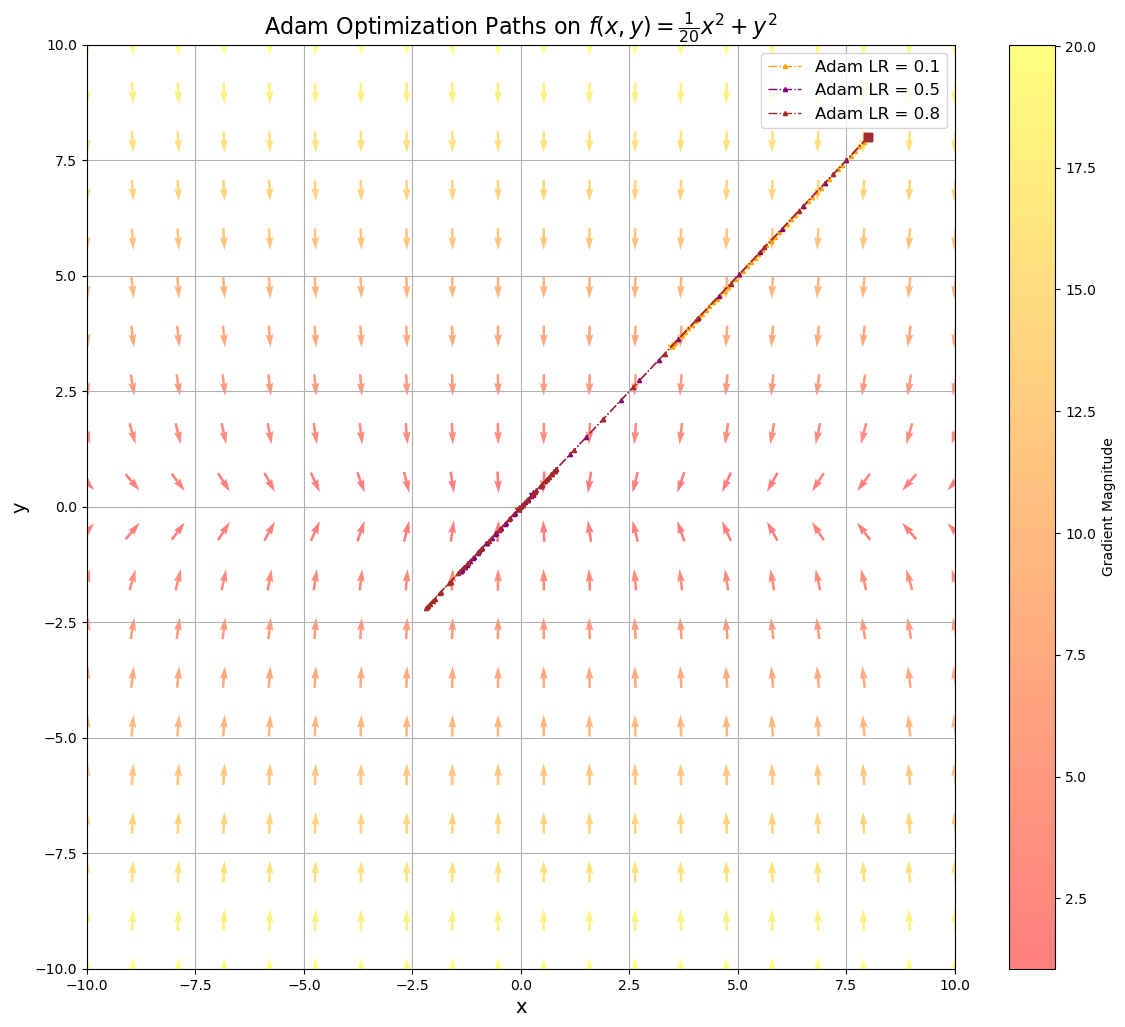

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# 定义目标函数 f(x, y) = (1/20)x^2 + y^2
def f(x, y):
    return (1/20) * x**2 + y**2

# 定义梯度函数 ∇f(x, y) = (1/10 x, 2y)
def gradient_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# 定义SGD优化器
class SGD:
    def __init__(self, lr=0.01):
        """
        初始化SGD优化器。

        参数:
        lr (float): 学习率。
        """
        self.lr = lr

    def update(self, params, grads):
        """
        使用SGD更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        return params - self.lr * grads

# 定义Momentum优化器
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        """
        初始化 Momentum 优化器。

        参数:
        lr (float): 学习率。
        momentum (float): 动量系数。
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None  # 速度向量

    def update(self, params, grads):
        """
        使用 Momentum 更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        if self.v is None:
            self.v = np.zeros_like(params)

        self.v = self.momentum * self.v - self.lr * grads
        params = params + self.v
        return params

# 定义Adam优化器
class Adam:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        初始化 Adam 优化器。

        参数:
        lr (float): 学习率。
        beta1 (float): 一阶矩的衰减率。
        beta2 (float): 二阶矩的衰减率。
        epsilon (float): 防止除零的小常数。
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # 一阶矩
        self.v = None  # 二阶矩
        self.t = 0     # 时间步

    def update(self, params, grads):
        """
        使用 Adam 更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)

        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)

        # 偏差修正
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # 更新参数
        params = params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return params

# 定义函数来执行SGD并记录路径
def run_sgd(initial_params, learning_rate, epochs):
    """
    执行SGD优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    epochs (int): 迭代次数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = SGD(lr=learning_rate)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 定义函数来执行Momentum并记录路径
def run_momentum(initial_params, learning_rate, momentum_coeff, epochs):
    """
    执行Momentum优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    momentum_coeff (float): 动量系数。
    epochs (int): 迭代次数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = Momentum(lr=learning_rate, momentum=momentum_coeff)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 定义函数来执行Adam并记录路径
def run_adam(initial_params, learning_rate, epochs, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    执行Adam优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    epochs (int): 迭代次数。
    beta1 (float): 一阶矩的衰减率。
    beta2 (float): 二阶矩的衰减率。
    epsilon (float): 防止除零的小常数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = Adam(lr=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 生成合成数据
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # 100 个样本，每个样本有一个特征
y = 4 + 3 * X + np.random.randn(100, 1)  # 线性关系 y = 4 + 3x + 噪声

# 生成绘图网格
x = np.linspace(-10, 10, 20)  # 较少的点以避免箭头过于密集
y_grid = np.linspace(-10, 10, 20)
X_grid, Y_grid = np.meshgrid(x, y_grid)
U, V = gradient_f(X_grid, Y_grid)
# 计算负梯度，用于绘制梯度场指向下降方向
U_neg, V_neg = -U, -V
# 归一化梯度向量以控制箭头长度
M = np.hypot(U_neg, V_neg)
M[M == 0] = 1  # 避免除以零
U_normalized = U_neg / M
V_normalized = V_neg / M

# 定义不同的学习率
learning_rates = [0.1, 0.5, 0.8]
colors_sgd = ['cyan', 'magenta', 'yellow']
colors_momentum = ['blue', 'green', 'red']
colors_adam = ['orange', 'purple', 'brown']
labels = [f'LR = {lr}' for lr in learning_rates]

# 初始化图形
plt.figure(figsize=(14, 12))

# 绘制梯度场
plt.quiver(X_grid, Y_grid, U_normalized, V_normalized, M, pivot='middle', cmap='autumn', alpha=0.5, scale=40)
plt.colorbar(label='Gradient Magnitude')

# 初始参数
initial_params_sgd = np.array([8.0, 8.0])
initial_params_momentum = np.array([8.0, 8.0])
initial_params_adam = np.array([8.0, 8.0])

# 记录并绘制每个学习率的Adam路径
for lr, color, label in zip(learning_rates, colors_adam, labels):
    # 运行Adam
    adam_path = run_adam(initial_params_adam, lr, epochs=50)
    plt.plot(adam_path[:, 0], adam_path[:, 1], marker='^', color=color, linestyle='-.', label=f'Adam {label}', markersize=3, linewidth=1)
    plt.plot(adam_path[0, 0], adam_path[0, 1], marker='s', color=color, markersize=6)  # 起点
    plt.plot(adam_path[-1, 0], adam_path[-1, 1], marker='*', color=color, markersize=6)  # 终点

# 设置标题和标签
plt.title(r'Adam Optimization Paths on $f(x, y) = \frac{1}{20}x^2 + y^2$', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

# 设置坐标轴范围
plt.xlim(-10, 10)
plt.ylim(-10, 10)

# 添加图例
plt.legend(loc='upper right', fontsize=12)

# 添加网格
plt.grid(True)

# 显示图形
plt.show()

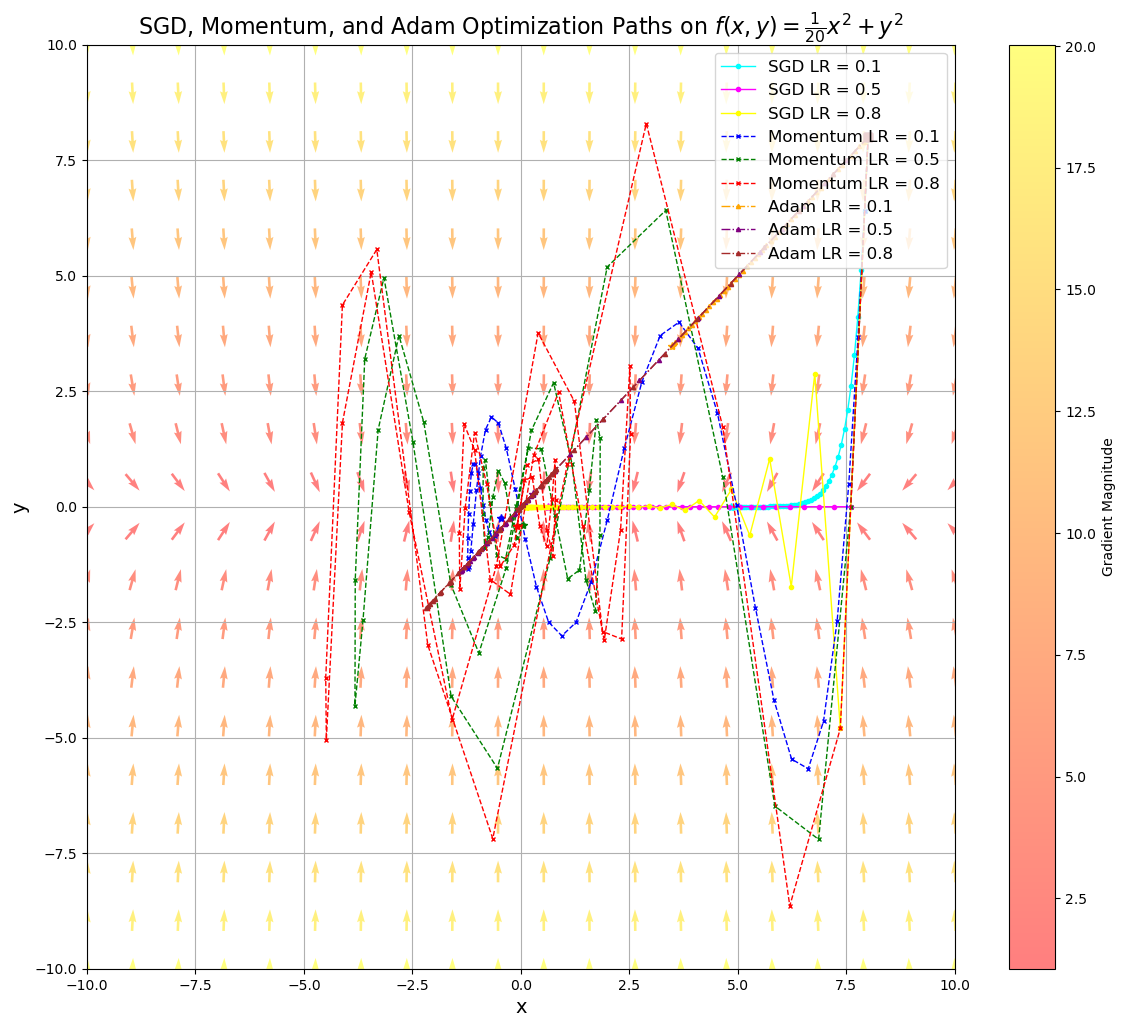

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# 定义目标函数 f(x, y) = (1/20)x^2 + y^2
def f(x, y):
    return (1/20) * x**2 + y**2

# 定义梯度函数 ∇f(x, y) = (1/10 x, 2y)
def gradient_f(x, y):
    df_dx = (1/10) * x
    df_dy = 2 * y
    return np.array([df_dx, df_dy])

# 定义SGD优化器
class SGD:
    def __init__(self, lr=0.01):
        """
        初始化SGD优化器。

        参数:
        lr (float): 学习率。
        """
        self.lr = lr

    def update(self, params, grads):
        """
        使用SGD更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        return params - self.lr * grads

# 定义Momentum优化器
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        """
        初始化 Momentum 优化器。

        参数:
        lr (float): 学习率。
        momentum (float): 动量系数。
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None  # 速度向量

    def update(self, params, grads):
        """
        使用 Momentum 更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        if self.v is None:
            self.v = np.zeros_like(params)

        self.v = self.momentum * self.v - self.lr * grads
        params = params + self.v
        return params

# 定义Adam优化器
class Adam:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        初始化 Adam 优化器。

        参数:
        lr (float): 学习率。
        beta1 (float): 一阶矩的衰减率。
        beta2 (float): 二阶矩的衰减率。
        epsilon (float): 防止除零的小常数。
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # 一阶矩
        self.v = None  # 二阶矩
        self.t = 0     # 时间步

    def update(self, params, grads):
        """
        使用 Adam 更新参数。

        参数:
        params (np.ndarray): 参数向量 [x, y]。
        grads (np.ndarray): 梯度向量 [df/dx, df/dy]。

        返回:
        np.ndarray: 更新后的参数向量。
        """
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)

        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)

        # 偏差修正
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # 更新参数
        params = params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return params

# 定义函数来执行SGD并记录路径
def run_sgd(initial_params, learning_rate, epochs):
    """
    执行SGD优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    epochs (int): 迭代次数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = SGD(lr=learning_rate)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 定义函数来执行Momentum并记录路径
def run_momentum(initial_params, learning_rate, momentum_coeff, epochs):
    """
    执行Momentum优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    momentum_coeff (float): 动量系数。
    epochs (int): 迭代次数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = Momentum(lr=learning_rate, momentum=momentum_coeff)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 定义函数来执行Adam并记录路径
def run_adam(initial_params, learning_rate, epochs, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    执行Adam优化并记录参数更新路径。

    参数:
    initial_params (np.ndarray): 初始参数向量 [x, y]。
    learning_rate (float): 学习率。
    epochs (int): 迭代次数。
    beta1 (float): 一阶矩的衰减率。
    beta2 (float): 二阶矩的衰减率。
    epsilon (float): 防止除零的小常数。

    返回:
    np.ndarray: 参数更新路径。
    """
    optimizer = Adam(lr=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    params = initial_params.copy()
    path = [params.copy()]

    for epoch in range(epochs):
        grads = gradient_f(params[0], params[1])
        params = optimizer.update(params, grads)
        path.append(params.copy())

    return np.array(path)

# 生成合成数据
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # 100 个样本，每个样本有一个特征
y = 4 + 3 * X + np.random.randn(100, 1)  # 线性关系 y = 4 + 3x + 噪声

# 生成绘图网格
x = np.linspace(-10, 10, 20)  # 较少的点以避免箭头过于密集
y_grid = np.linspace(-10, 10, 20)
X_grid, Y_grid = np.meshgrid(x, y_grid)
U, V = gradient_f(X_grid, Y_grid)
# 计算负梯度，用于绘制梯度场指向下降方向
U_neg, V_neg = -U, -V
# 归一化梯度向量以控制箭头长度
M = np.hypot(U_neg, V_neg)
M[M == 0] = 1  # 避免除以零
U_normalized = U_neg / M
V_normalized = V_neg / M

# 定义不同的学习率
learning_rates = [0.1, 0.5, 0.8]
colors_sgd = ['cyan', 'magenta', 'yellow']
colors_momentum = ['blue', 'green', 'red']
colors_adam = ['orange', 'purple', 'brown']
labels = [f'LR = {lr}' for lr in learning_rates]

# 初始化图形
plt.figure(figsize=(14, 12))

# 绘制梯度场
plt.quiver(X_grid, Y_grid, U_normalized, V_normalized, M, pivot='middle', cmap='autumn', alpha=0.5, scale=40)
plt.colorbar(label='Gradient Magnitude')

# 初始参数
initial_params_sgd = np.array([8.0, 8.0])
initial_params_momentum = np.array([8.0, 8.0])
initial_params_adam = np.array([8.0, 8.0])

# 记录并绘制每个学习率的SGD路径
for lr, color, label in zip(learning_rates, colors_sgd, labels):
    # 运行SGD
    sgd_path = run_sgd(initial_params_sgd, lr, epochs=50)
    plt.plot(sgd_path[:, 0], sgd_path[:, 1], marker='o', color=color, linestyle='-', label=f'SGD {label}', markersize=3, linewidth=1)
    plt.plot(sgd_path[0, 0], sgd_path[0, 1], marker='s', color=color, markersize=6)  # 起点
    plt.plot(sgd_path[-1, 0], sgd_path[-1, 1], marker='*', color=color, markersize=6)  # 终点

# 记录并绘制每个学习率的Momentum路径
for lr, color, label in zip(learning_rates, colors_momentum, labels):
    # 运行Momentum
    momentum_path = run_momentum(initial_params_momentum, lr, momentum_coeff=0.9, epochs=50)
    plt.plot(momentum_path[:, 0], momentum_path[:, 1], marker='x', color=color, linestyle='--', label=f'Momentum {label}', markersize=3, linewidth=1)
    plt.plot(momentum_path[0, 0], momentum_path[0, 1], marker='s', color=color, markersize=6)  # 起点
    plt.plot(momentum_path[-1, 0], momentum_path[-1, 1], marker='*', color=color, markersize=6)  # 终点

# 记录并绘制每个学习率的Adam路径
for lr, color, label in zip(learning_rates, colors_adam, labels):
    # 运行Adam
    adam_path = run_adam(initial_params_adam, lr, epochs=50)
    plt.plot(adam_path[:, 0], adam_path[:, 1], marker='^', color=color, linestyle='-.', label=f'Adam {label}', markersize=3, linewidth=1)
    plt.plot(adam_path[0, 0], adam_path[0, 1], marker='s', color=color, markersize=6)  # 起点
    plt.plot(adam_path[-1, 0], adam_path[-1, 1], marker='*', color=color, markersize=6)  # 终点

# 设置标题和标签
plt.title(r'SGD, Momentum, and Adam Optimization Paths on $f(x, y) = \frac{1}{20}x^2 + y^2$', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

# 设置坐标轴范围
plt.xlim(-10, 10)
plt.ylim(-10, 10)

# 添加图例
plt.legend(loc='upper right', fontsize=12)

# 添加网格
plt.grid(True)

# 显示图形
plt.show()

## 权重的初始值

在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，经常关系到神经网络的学习能否成功。

当所有神经网络的权重初始化为零时，会导致一系列严重的问题，阻碍网络的有效学习。

当所有神经元的权重和偏置都被初始化为零时，会发生以下情况：

1. 相同的输入，产生相同的输出：

假设输入向量为  $\mathbf{x}$，每个神经元的权重向量 $\mathbf{w}$  和偏置  $b$  都是零。因此，对于每个神经元  $j$ ，其输出  $y_j$  计算如下：

$$
y_j = \sigma(\mathbf{w}_j \cdot \mathbf{x} + b_j) = \sigma(0 + 0) = \sigma(0)
$$

其中， $\sigma$  是激活函数（例如，Sigmoid、ReLU等）。由于所有权重和偏置相同，每个神经元计算出的输出  $y_j$  也是相同的。

2. 相同的梯度，导致相同的权重更新：

在反向传播过程中，损失函数相对于每个权重的梯度计算如下：

$$
\frac{\partial L}{\partial \mathbf{w}_j} = \frac{\partial L}{\partial y_j} \cdot \frac{\partial y_j}{\partial \mathbf{w}_j}
$$

由于所有神经元的输出  $y_j$  相同，并且权重和偏置相同，所有神经元的梯度  $\frac{\partial L}{\partial \mathbf{w}_j}$  也是相同的。因此，在参数更新时：

$$
\mathbf{w}_j^{\text{new}} = \mathbf{w}_j^{\text{old}} - \eta \cdot \frac{\partial L}{\partial \mathbf{w}_j}
$$

这里  $\eta$  是学习率。由于所有梯度相同，所有神经元的权重  $\mathbf{w}_j$  和偏置  $b_j$  将以相同的方式更新，保持它们之间的对称性。

对称性破缺指的是通过某种方式（如随机初始化权重）打破神经元之间的对称性，使得每个神经元在训练过程中能够学习到不同的特征或表示。

通过随机初始化权重，可以打破神经元之间的对称性。不同的初始权重意味着即使输入相同，每个神经元的输出也会不同，从而在反向传播过程中接收到不同的梯度，导致它们以不同的方式更新参数，学习到不同的特征。

### 隐藏层的激活值的分布

观察隐藏层的激活值（激活函数的输出数据）的分布，可以获得很多启发。这里，我们来做一个简单的实验，观察权重初始值是如何影响隐藏层的激活值的分布的。这里要做的实验是，向一个5层神经网络（激活函数使用sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。

这里我们将激活函数的输出数据称为“激活值”

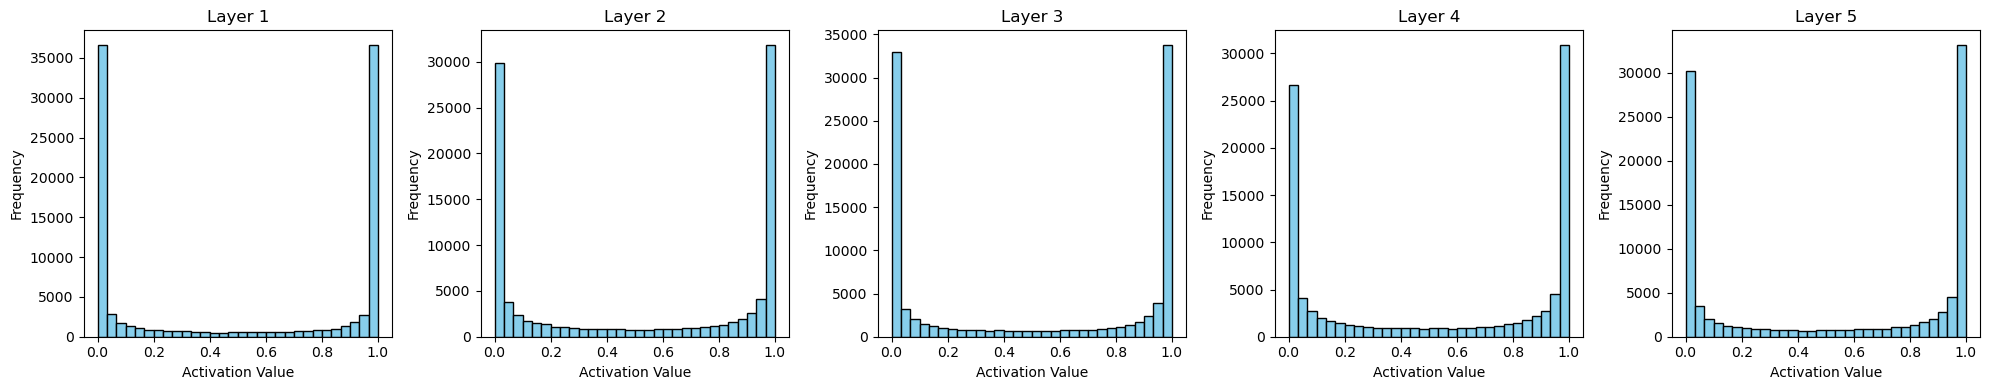

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 定义Sigmoid激活函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 生成初始输入数据
# x形状为 (1000, 100)，即1000个样本，每个样本有100个特征
x = np.random.randn(1000, 100)

# 定义神经网络结构参数
node_num = 100          # 每个隐藏层的节点（神经元）数
hidden_layer_size = 5   # 隐藏层数量

# 初始化字典以存储每一层的激活值
activations = {}

# 构建并前向传播神经网络
for i in range(hidden_layer_size):
    if i != 0:
        # 对于非第一层，输入为前一层的激活值
        x = activations[i-1]
    
    # 初始化权重矩阵，形状为 (100, 100)，均值为0，标准差为1
    # 可以根据需要调整初始化方法，例如使用He初始化或Xavier初始化
    w = np.random.randn(node_num, node_num) * 1
    
    # 计算线性组合 z = xW
    z = np.dot(x, w)
    
    # 应用Sigmoid激活函数
    a = sigmoid(z)
    
    # 将当前层的激活值存储在activations字典中
    activations[i] = a

# 绘制每一层激活值的直方图
plt.figure(figsize=(20, 4))  # 调整图形大小以适应多个子图

for i, a in activations.items():
    plt.subplot(1, hidden_layer_size, i+1)  # 创建1行5列的子图
    plt.title(f'Layer {i+1}')                # 设置子图标题
    plt.hist(a.flatten(), bins=30, range=(0, 1), color='skyblue', edgecolor='black')  # 绘制直方图
    plt.xlabel('Activation Value')           # 设置x轴标签
    plt.ylabel('Frequency')                  # 设置y轴标签

plt.tight_layout()  # 自动调整子图参数以适应图形区域
plt.show()          # 显示图形

这里假设神经网络有5层，每层有100个神经元。然后，用高斯分布随机生成1000个数据作为输入数据，并把它们传给5层神经网络。激活函数使用sigmoid函数，各层的激活值的结果保存在 activations 变量中。这个代码段中需要注意的是权重的尺度。虽然这次我们使用的是标准差为1的高斯分布，但实验的目的是通过改变这个尺度（标准差），观察激活值的分布如何变化。现在，我们将保存在 activations 中的各层数据画成直方图。

从图可知，各层的激活值呈偏向0和1的分布。这里使用的sigmoid函数是S型函数，随着输出不断地靠近0（或者靠近1），它的导数的值逐渐接近0。因此，偏向0和1的数据分布会造成反向传播中梯度的值不断变小，最后消失。这个问题称为**梯度消失（gradient vanishing）**。层次加深的深度学习中，梯度消失的问题可能会更加严重。

* Sigmoid函数：

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

导数：

$$
\sigma{\prime}(x) = \sigma(x) \cdot (1 - \sigma(x))
$$

当 $x$  很大或很小时， $\sigma{\prime}(x)$  接近于0。

随着网络层数的增加，反向传播时链式法则的应用导致梯度值会被多次相乘。如果每层的梯度值小于1，最终累积的梯度会非常小，导致参数更新微乎其微。

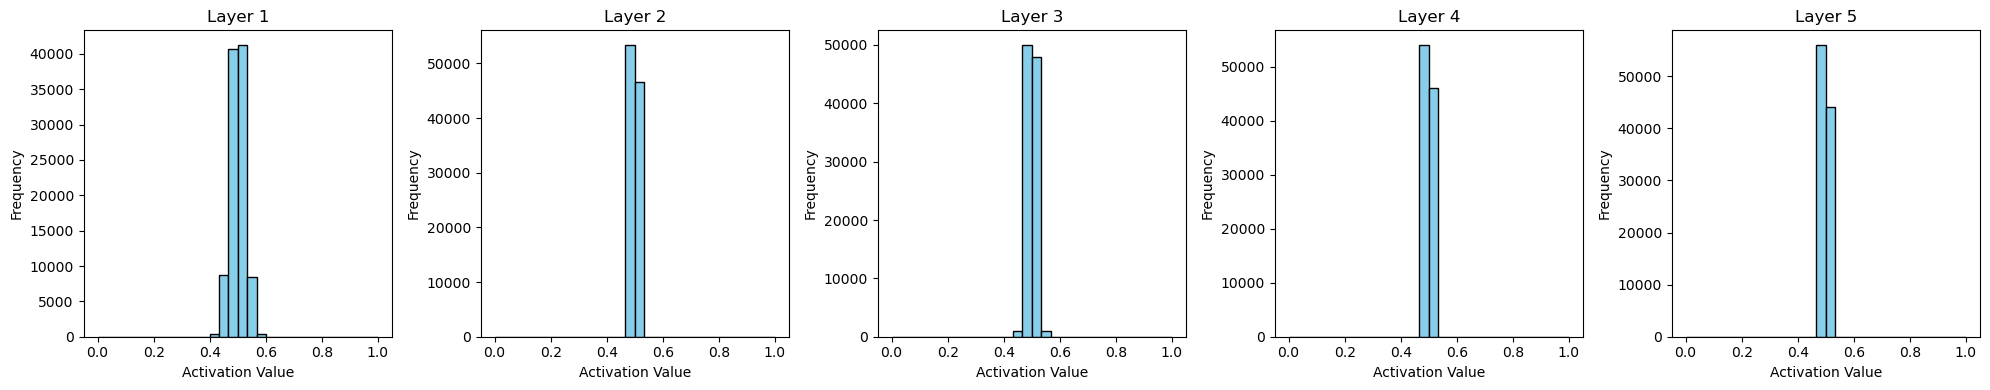

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# 定义Sigmoid激活函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 生成初始输入数据
# x形状为 (1000, 100)，即1000个样本，每个样本有100个特征
x = np.random.randn(1000, 100)

# 定义神经网络结构参数
node_num = 100          # 每个隐藏层的节点（神经元）数
hidden_layer_size = 5   # 隐藏层数量

# 初始化字典以存储每一层的激活值
activations = {}

# 构建并前向传播神经网络
for i in range(hidden_layer_size):
    if i != 0:
        # 对于非第一层，输入为前一层的激活值
        x = activations[i-1]
    
    # 初始化权重矩阵，形状为 (100, 100)，均值为0，标准差为1
    # 可以根据需要调整初始化方法，例如使用He初始化或Xavier初始化
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    
    # 计算线性组合 z = xW
    z = np.dot(x, w)
    
    # 应用Sigmoid激活函数
    a = sigmoid(z)
    
    # 将当前层的激活值存储在activations字典中
    activations[i] = a

# 绘制每一层激活值的直方图
plt.figure(figsize=(20, 4))  # 调整图形大小以适应多个子图

for i, a in activations.items():
    plt.subplot(1, hidden_layer_size, i+1)  # 创建1行5列的子图
    plt.title(f'Layer {i+1}')                # 设置子图标题
    plt.hist(a.flatten(), bins=30, range=(0, 1), color='skyblue', edgecolor='black')  # 绘制直方图
    plt.xlabel('Activation Value')           # 设置x轴标签
    plt.ylabel('Frequency')                  # 设置y轴标签

plt.tight_layout()  # 自动调整子图参数以适应图形区域
plt.show()          # 显示图形

来看一下结果。使用标准差为0.01的高斯分布时，各层的激活值的分布 如图6-11所示。这次呈集中在0.5附近的分布。因为不像刚才的例子那样偏向0和1，所以不会发生梯度消失的问题。但是，激活值的分布有所偏向，说明在表现力上会有很大问题。为什么这么说呢？因为如果有多个神经元都输出几乎相同的值，那它们就没有存在的意义了。比如，如果100个神经元都输出几乎相同的值，那么也可以由1个神经元来表达基本相同的事情。因此，激活值在分布上有所偏向会出现“表现力受限”的问题。

表现力受限问题（Limited Expressiveness 或 Limited Representation Power）是指神经网络在建模复杂函数或捕捉复杂数据模式时，由于网络结构、参数数量或其他因素的限制，无法有效表示或学习这些复杂性。这一问题会导致模型在面对复杂任务时性能不佳，无法充分发挥其潜力。

### Sigmoid函数的权重Xavier初始值

Xavier初始化（Xavier Initialization），也被称为Glorot初始化，是一种在训练深度神经网络时用来初始化权重的方法。该方法由Xavier Glorot和Yoshua Bengio在2010年的论文《Understanding the difficulty of training deep feedforward neural networks》中提出。Xavier初始化旨在保持前向传播和反向传播过程中信号的方差稳定，避免梯度消失或爆炸的问题，从而加速网络的收敛并提升训练效果。

* 梯度消失（Vanishing Gradient）：梯度在反向传播过程中逐渐变小，导致前面几层几乎不更新权重，网络难以学习。
* 梯度爆炸（Exploding Gradient）：梯度在反向传播过程中逐渐变大，导致权重更新过大，训练不稳定。

对于一个具有线性激活函数或双曲正切（Tanh）激活函数的神经元，Xavier初始化的权重$W$通常遵循以下分布：
* 均匀分布（Uniform Distribution）：

$$
W \sim \text{Uniform}\left(-\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}, \sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}\right)
$$

* 正态分布（Normal Distribution）：

$$
W \sim \mathcal{N}\left(0, \frac{2}{n_{\text{in}} + n_{\text{out}}}\right)
$$

其中：
* $n_{\text{in}}$ 是该层的输入神经元数量。
* $n_{\text{out}}$ 是该层的输出神经元数量。

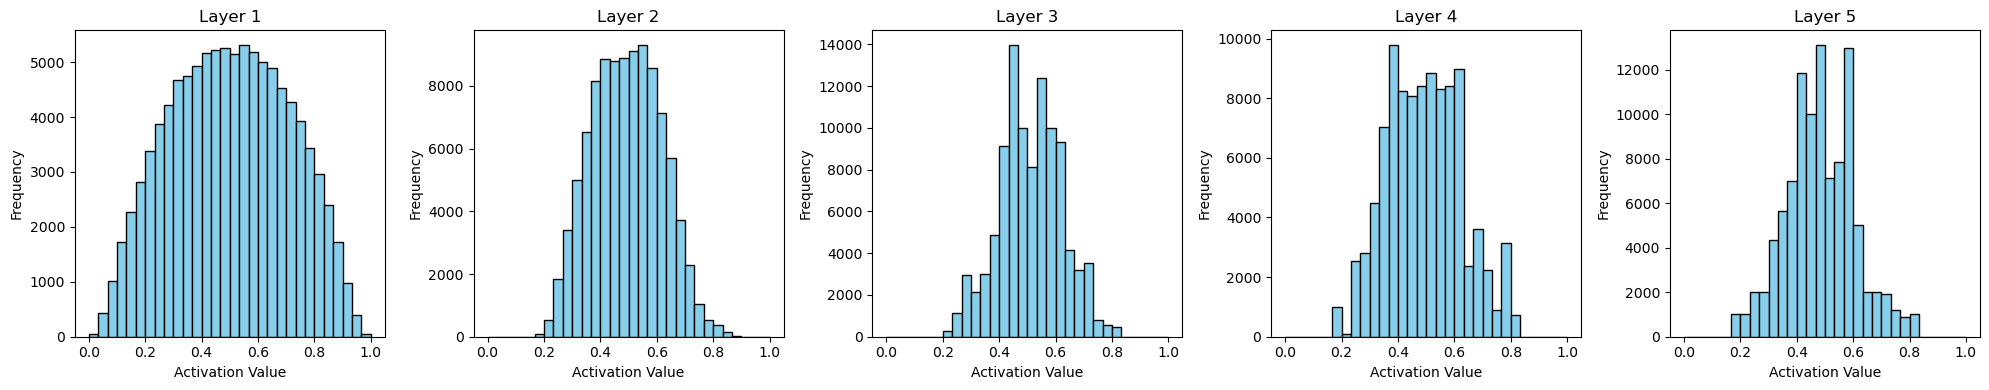

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# 定义Sigmoid激活函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 定义Xavier初始化函数（使用均匀分布）
def xavier_uniform_init(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=(n_in, n_out))

# 或者，定义Xavier初始化函数（使用正态分布）
def xavier_normal_init(n_in, n_out):
    std_dev = np.sqrt(2 / (n_in + n_out))
    return np.random.randn(n_in, n_out) * std_dev
    
# 生成初始输入数据
# x形状为 (1000, 100)，即1000个样本，每个样本有100个特征
x = np.random.randn(1000, 100)

# 定义神经网络结构参数
node_num = 100          # 每个隐藏层的节点（神经元）数
hidden_layer_size = 5   # 隐藏层数量

# 初始化字典以存储每一层的激活值
activations = {}

# 构建并前向传播神经网络
for i in range(hidden_layer_size):
    if i != 0:
        # 对于非第一层，输入为前一层的激活值
        x = activations[i-1]
    
    # 初始化权重矩阵，形状为 (100, 100)，均值为0，标准差为1
    # 可以根据需要调整初始化方法，例如使用He初始化或Xavier初始化
    # w = np.random.randn(node_num, node_num) * 1
    w = xavier_normal_init(node_num, node_num)
    
    # 计算线性组合 z = xW
    z = np.dot(x, w)
    
    # 应用Sigmoid激活函数
    a = sigmoid(z)
    
    # 将当前层的激活值存储在activations字典中
    activations[i] = a

# 绘制每一层激活值的直方图
plt.figure(figsize=(20, 4))  # 调整图形大小以适应多个子图

for i, a in activations.items():
    plt.subplot(1, hidden_layer_size, i+1)  # 创建1行5列的子图
    plt.title(f'Layer {i+1}')                # 设置子图标题
    plt.hist(a.flatten(), bins=30, range=(0, 1), color='skyblue', edgecolor='black')  # 绘制直方图
    plt.xlabel('Activation Value')           # 设置x轴标签
    plt.ylabel('Frequency')                  # 设置y轴标签

plt.tight_layout()  # 自动调整子图参数以适应图形区域
plt.show()          # 显示图形

使用Xavier初始值后的结果如图所示。从这个结果可知，越是后面的层，图像变得越歪斜，但是呈现了比之前更有广度的分布。因为各层间 传递的数据有适当的广度，所以sigmoid函数的表现力不受限制，有望进行 高效的学习。

### ReLU的权重初始值

Xavier初始值是以激活函数是线性函数为前提而推导出来的。因为 sigmoid 函数和 tanh 函数左右对称，且中央附近可以视作线性函数，所以适 合使用Xavier初始值。但当激活函数使用ReLU时，一般推荐使用ReLU专用的初始值，也就是Kaiming He等人推荐的初始值， 也称为“He初始值” 。 当前一层的节点数为$n$时， He初始值使用标准差为$\sqrt{\frac{2}{n}}$的高斯分布。当 Xavier初始值是$\sqrt{\frac{1}{n}}$时，（直观上）可以解释为，因为ReLU的负值区域的值为0，为了使它更有广度，所以需要2倍的系数。

* He正态初始化

对于使用ReLU及其变种激活函数的神经网络，He正态初始化的方法如下：

$$
W \sim \mathcal{N}\left(0, \frac{2}{n_{\text{in}}}\right)
$$

其中：
* $W$  是权重矩阵。
* $n_{\text{in}}$  是该层的输入神经元数量。
* $\mathcal{N}(0, \frac{2}{n_{\text{in}}})$  表示均值为0，方差为  $\frac{2}{n_{\text{in}}}$  的正态分布。

* He均匀初始化

另一种常用的He初始化方法是基于均匀分布：

$$
W \sim \text{Uniform}\left(-\sqrt{\frac{6}{n_{\text{in}}}}, \sqrt{\frac{6}{n_{\text{in}}}}\right)
$$

这种方法同样旨在保持信号的方差稳定，但使用的是均匀分布而非正态分布。


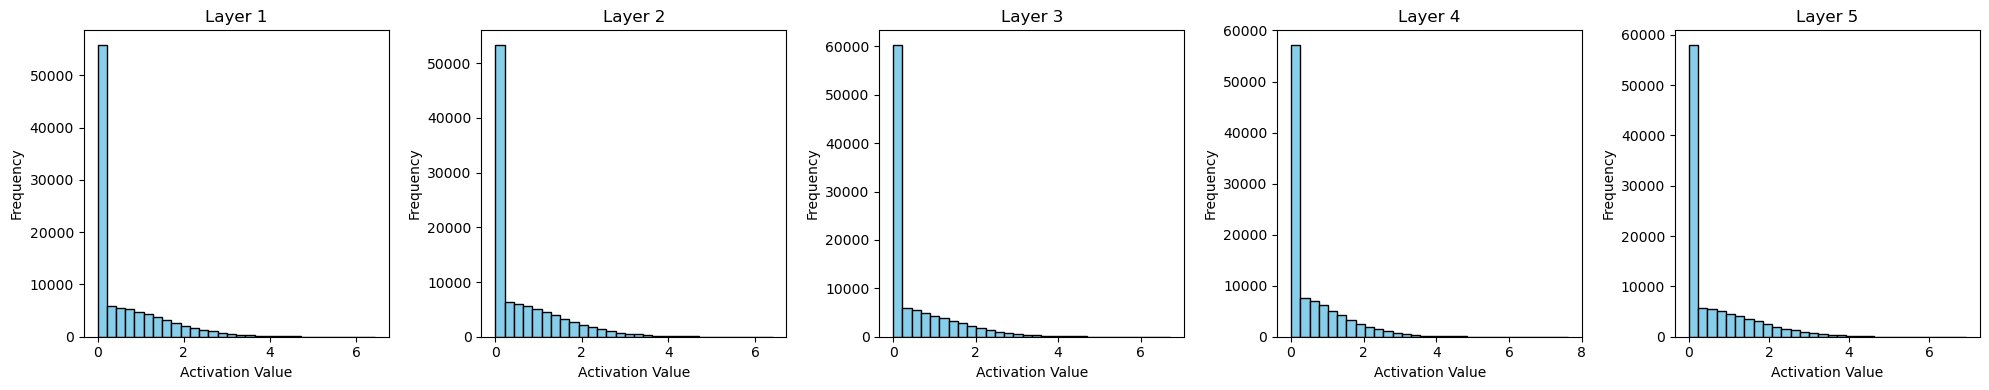

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# 定义ReLU激活函数
def relu(x):
    return np.maximum(0, x)

# 定义He正态初始化函数
def he_normal_init(n_in, n_out):
    """
    He正态初始化
    参数:
        n_in (int): 输入神经元数量
        n_out (int): 输出神经元数量
    返回:
        numpy.ndarray: 初始化后的权重矩阵
    """
    std_dev = np.sqrt(2. / n_in)
    return np.random.randn(n_in, n_out) * std_dev

# 或者，定义He均匀初始化函数
def he_uniform_init(n_in, n_out):
    """
    He均匀初始化
    参数:
        n_in (int): 输入神经元数量
        n_out (int): 输出神经元数量
    返回:
        numpy.ndarray: 初始化后的权重矩阵
    """
    limit = np.sqrt(6. / n_in)
    return np.random.uniform(-limit, limit, size=(n_in, n_out))

# 生成初始输入数据
# x形状为 (1000, 100)，即1000个样本，每个样本有100个特征
x = np.random.randn(1000, 100)

# 定义神经网络结构参数
node_num = 100          # 每个隐藏层的节点（神经元）数
hidden_layer_size = 5   # 隐藏层数量

# 初始化字典以存储每一层的激活值
activations = {}

# 构建并前向传播神经网络
for i in range(hidden_layer_size):
    if i != 0:
        # 对于非第一层，输入为前一层的激活值
        x = activations[i-1]
    
    # 使用He初始化权重矩阵，形状为 (100, 100)
    # 选择使用He正态初始化或He均匀初始化
    
    # 方法1：使用He正态初始化
    w = he_normal_init(node_num, node_num)
    
    # 方法2：使用He均匀初始化
    # w = he_uniform_init(node_num, node_num)
    
    # 计算线性组合 z = xW
    z = np.dot(x, w)
    
    # 应用ReLU激活函数
    a = relu(z)
    
    # 将当前层的激活值存储在activations字典中
    activations[i] = a

# 绘制每一层激活值的直方图
plt.figure(figsize=(20, 4))  # 调整图形大小以适应多个子图

for i, a in activations.items():
    plt.subplot(1, hidden_layer_size, i+1)  # 创建1行5列的子图
    plt.title(f'Layer {i+1}')                # 设置子图标题
    plt.hist(a.flatten(), bins=30, color='skyblue', edgecolor='black')  # 绘制直方图
    plt.xlabel('Activation Value')           # 设置x轴标签
    plt.ylabel('Frequency')                  # 设置y轴标签

plt.tight_layout()  # 自动调整子图参数以适应图形区域
plt.show()          # 显示图形

## Batch Normalization

Batch Normalization（批量归一化）是深度神经网络中常用的一种技术，旨在加速训练过程、提高模型稳定性并提升最终的模型性能。

在深度神经网络的训练过程中，网络的每一层输入分布可能会发生变化，这被称为内部协变量偏移（Internal Covariate Shift）。这种变化会导致训练变得缓慢，因为每一层需要不断适应输入分布的变化。Batch Normalization通过标准化每一层的输入，减少这种偏移，从而加快训练速度并提高模型性能。

Batch Norm的思路是调整各层的激活值分布使其拥有适当 的广度。为此，要向神经网络中插入对数据分布进行正规化的层，即Batch Normalization层 （下文简称Batch Norm层）

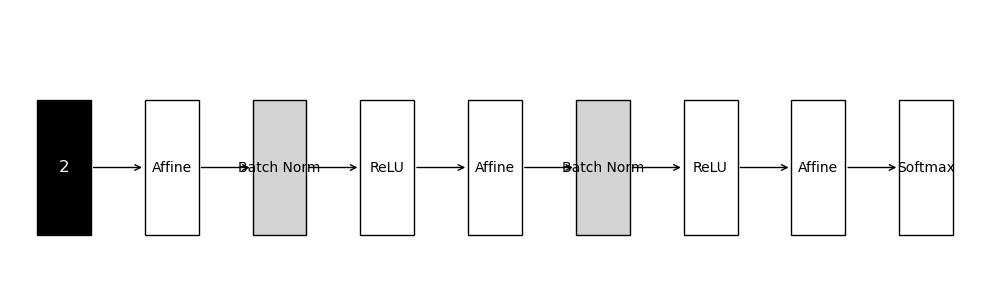

In [135]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_block(ax, xy, width, height, text, facecolor='white', edgecolor='black'):
    """
    在指定坐标 (xy) 处绘制一个矩形块，并在其中心写文字。
    facecolor: 填充色
    edgecolor: 边框色
    """
    rect = patches.Rectangle(
        xy, width, height, 
        facecolor=facecolor, 
        edgecolor=edgecolor,
        linewidth=1
    )
    ax.add_patch(rect)
    
    # 在矩形块中心位置添加文本
    cx = xy[0] + width / 2
    cy = xy[1] + height / 2
    ax.text(cx, cy, text, 
            ha='center', va='center', 
            fontsize=10)

def draw_arrow(ax, start, end):
    """
    在 start 与 end 之间画一条箭头。
    start, end: (x, y) 坐标
    """
    ax.annotate(
        '', 
        xy=end, 
        xytext=start, 
        arrowprops=dict(arrowstyle='->', linewidth=1)
    )

# 创建画布
fig, ax = plt.subplots(figsize=(10, 3))

# 关闭坐标轴（仅保留示意图）
ax.set_axis_off()

# 参数设置
block_width = 1.0
block_height = 1.5
y_base = 0.5   # 所有方块左下角的 y 坐标

# 1. MNIST数字图像
# 用一个小黑方块表示，内部用白色文字写个 "2"
draw_block(ax, (0, y_base), block_width, block_height, text='', facecolor='black')
ax.text(0.5, y_base + block_height/2, '2', 
        ha='center', va='center', color='white', fontsize=12)

# 2. 箭头：图像 -> Affine
draw_arrow(ax, (block_width, y_base + block_height/2), (block_width+1, y_base + block_height/2))

# 3. Affine 层
x_affine1 = block_width + 1.0
draw_block(ax, (x_affine1, y_base), block_width, block_height, text='Affine')

# 4. 箭头：Affine -> Batch Norm
draw_arrow(ax, (x_affine1 + block_width, y_base + block_height/2), 
               (x_affine1 + block_width + 1, y_base + block_height/2))

# 5. Batch Norm 层（灰色背景）
x_bn1 = x_affine1 + block_width + 1.0
draw_block(ax, (x_bn1, y_base), block_width, block_height, text='Batch Norm', facecolor='lightgray')

# 6. 箭头：Batch Norm -> ReLU
draw_arrow(ax, (x_bn1 + block_width, y_base + block_height/2), 
               (x_bn1 + block_width + 1, y_base + block_height/2))

# 7. ReLU 层
x_relu1 = x_bn1 + block_width + 1.0
draw_block(ax, (x_relu1, y_base), block_width, block_height, text='ReLU')

# 8. 箭头：ReLU -> Affine
draw_arrow(ax, (x_relu1 + block_width, y_base + block_height/2), 
               (x_relu1 + block_width + 1, y_base + block_height/2))

# 9. Affine 层
x_affine2 = x_relu1 + block_width + 1.0
draw_block(ax, (x_affine2, y_base), block_width, block_height, text='Affine')

# 10. 箭头：Affine -> Batch Norm
draw_arrow(ax, (x_affine2 + block_width, y_base + block_height/2), 
               (x_affine2 + block_width + 1, y_base + block_height/2))

# 11. Batch Norm 层（灰色背景）
x_bn2 = x_affine2 + block_width + 1.0
draw_block(ax, (x_bn2, y_base), block_width, block_height, text='Batch Norm', facecolor='lightgray')

# 12. 箭头：Batch Norm -> ReLU
draw_arrow(ax, (x_bn2 + block_width, y_base + block_height/2), 
               (x_bn2 + block_width + 1, y_base + block_height/2))

# 13. ReLU 层
x_relu2 = x_bn2 + block_width + 1.0
draw_block(ax, (x_relu2, y_base), block_width, block_height, text='ReLU')

# 14. 箭头：ReLU -> Affine
draw_arrow(ax, (x_relu2 + block_width, y_base + block_height/2), 
               (x_relu2 + block_width + 1, y_base + block_height/2))

# 15. Affine 层
x_affine3 = x_relu2 + block_width + 1.0
draw_block(ax, (x_affine3, y_base), block_width, block_height, text='Affine')

# 16. 箭头：Affine -> Softmax
draw_arrow(ax, (x_affine3 + block_width, y_base + block_height/2), 
               (x_affine3 + block_width + 1, y_base + block_height/2))

# 17. Softmax 层
x_softmax = x_affine3 + block_width + 1.0
draw_block(ax, (x_softmax, y_base), block_width, block_height, text='Softmax')

# 适当留白，让图形呈现在可见范围内
ax.set_xlim(-0.5, x_softmax + block_width + 0.5)
ax.set_ylim(0, 3)

plt.tight_layout()
plt.show()

Batch Norm， 顾名思义，以进行学习时的mini-batch为单位，按minibatch进行正规化。 具体而言，就是进行使数据分布的均值为0、方差为1的正规化。用数学式表示的话，如下所示。

<span style="color: red;">**计算批次均值和方差**</span>

对于给定的一个小批量（mini-batch）数据，计算每个特征维度的均值和方差。

假设输入数据为一个小批量的样本集合  $\{x_1, x_2, \ldots, x_m\}$ ，其中  $m$  是批量大小。
* 均值：

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

* 方差：

$$
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

<span style="color: red;">**标准化**</span>

使用计算得到的均值和方差对输入进行标准化，使其具有零均值和单位方差。

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

其中， $\epsilon$  是一个小常数，用于防止分母为零。

<span style="color: red;">**缩放和平移**</span>

引入两个可训练的参数， $\gamma$  和  $\beta$ ，对标准化后的数据进行缩放和平移，以恢复网络的表达能力。

$$
y_i = \gamma \hat{x}_i + \beta
$$


<span style="color: red;">**训练与推理阶段的处理**</span>
* 训练阶段：
使用当前批次的均值和方差进行标准化。同时，维护一个移动平均的均值和方差，用于推理阶段。
更新移动平均的方式通常为：

$$
\text{moving\_mean} = \text{momentum} \times \text{moving\_mean} + (1 - \text{momentum}) \times \mu
$$

$$
\text{moving\_variance} = \text{momentum} \times \text{moving\_variance} + (1 - \text{momentum}) \times \sigma^2
$$

其中， $\text{momentum}$  是一个超参数，通常取值接近1（如0.9）。
* 推理阶段：
使用训练期间累积的移动平均均值和方差进行标准化，而不是使用当前批次的数据。

$$
\hat{x}_i = \frac{x_i - \text{moving\_mean}}{\sqrt{\text{moving\_variance} + \epsilon}}
$$

$$
y_i = \gamma \hat{x}_i + \beta
$$

综合上述步骤，Batch Normalization的数学表达式如下：

$$
y_i = \gamma \left( \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta
$$

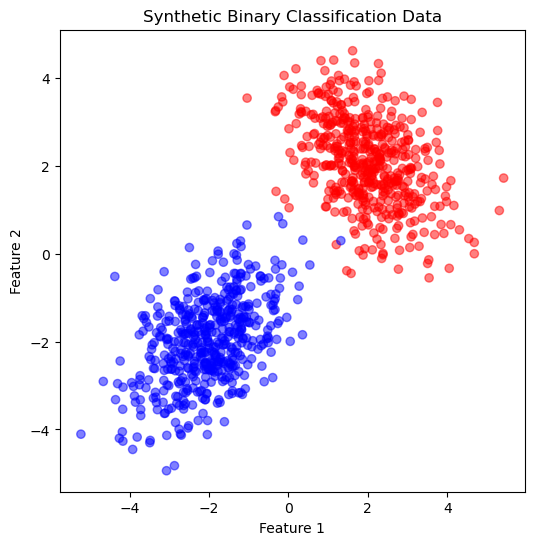

训练不使用Batch Normalization的模型...
不使用Batch Normalization的模型在测试集上的准确率: 100.00%

训练使用Batch Normalization的模型...
使用Batch Normalization的模型在测试集上的准确率: 100.00%


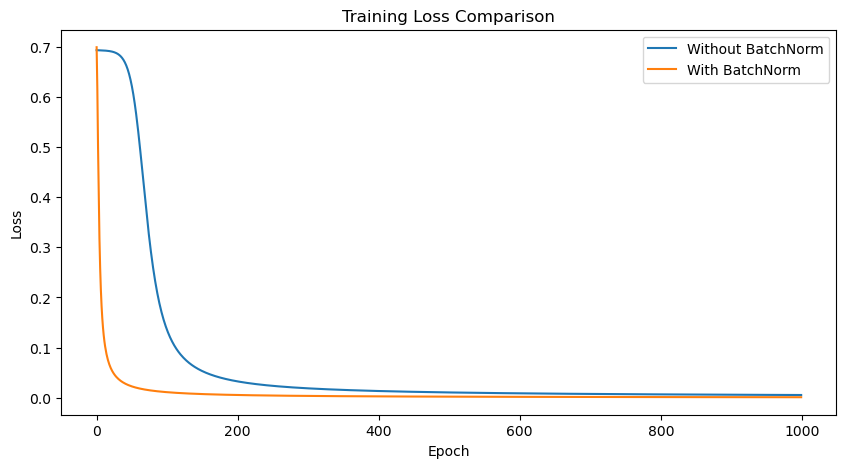

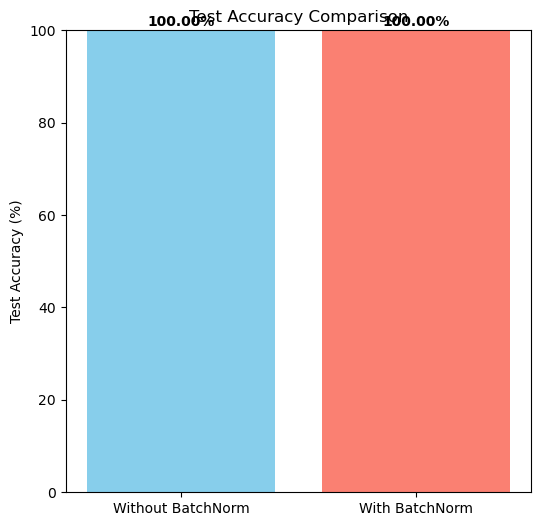

In [143]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子以保证结果可重复
np.random.seed(42)

# 1. 数据生成
def generate_data(n_samples=1000):
    # 生成第一类数据（中心在 (-2, -2)）
    mean1 = [-2, -2]
    cov1 = [[1, 0.5], [0.5, 1]]
    X1 = np.random.multivariate_normal(mean1, cov1, n_samples // 2)
    y1 = np.zeros((n_samples // 2, 1))

    # 生成第二类数据（中心在 (2, 2)）
    mean2 = [2, 2]
    cov2 = [[1, -0.5], [-0.5, 1]]
    X2 = np.random.multivariate_normal(mean2, cov2, n_samples // 2)
    y2 = np.ones((n_samples // 2, 1))

    # 合并数据
    X = np.vstack((X1, X2))
    y = np.vstack((y1, y2))

    # 打乱数据
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y

# 生成数据并可视化
X, y = generate_data(n_samples=1000)
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], cmap='bwr', alpha=0.5)
plt.title("Synthetic Binary Classification Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 2. 神经网络实现

# 2.1 不使用Batch Normalization的网络
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # 权重初始化
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X, training=True):  # 修改这里，添加training参数
        # 前向传播
        self.Z1 = np.dot(X, self.W1) + self.b1  # 隐藏层线性组合
        self.A1 = np.tanh(self.Z1)             # 激活函数
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # 输出层线性组合
        self.A2 = self.sigmoid(self.Z2)        # 输出激活函数（概率）
        return self.A2

    def compute_loss(self, Y, Y_hat):
        # 二元交叉熵损失
        m = Y.shape[0]
        loss = - (1/m) * np.sum(Y * np.log(Y_hat + 1e-8) + (1 - Y) * np.log(1 - Y_hat + 1e-8))
        return loss

    def backward(self, X, Y, Y_hat, learning_rate=0.1):
        m = Y.shape[0]

        # 输出层梯度
        dZ2 = Y_hat - Y  # (m, 1)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)  # (hidden_dim, 1)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)  # (1, 1)

        # 隐藏层梯度
        dA1 = np.dot(dZ2, self.W2.T)  # (m, hidden_dim)
        dZ1 = dA1 * (1 - np.power(self.A1, 2))  # tanh导数
        dW1 = (1/m) * np.dot(X.T, dZ1)  # (input_dim, hidden_dim)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)  # (1, hidden_dim)

        # 更新参数
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

# 2.2 使用Batch Normalization的网络
class NeuralNetworkBN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # 权重初始化
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        
        # BatchNorm参数
        self.gamma = np.ones((1, hidden_dim))
        self.beta = np.zeros((1, hidden_dim))
        self.epsilon = 1e-8

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X, training=True):
        # 前向传播
        self.Z1 = np.dot(X, self.W1) + self.b1  # 隐藏层线性组合
        
        # Batch Normalization
        if training:
            self.mu = np.mean(self.Z1, axis=0, keepdims=True)
            self.var = np.var(self.Z1, axis=0, keepdims=True)
            self.Z1_norm = (self.Z1 - self.mu) / np.sqrt(self.var + self.epsilon)
            self.A1_bn = self.gamma * self.Z1_norm + self.beta  # 缩放和平移
        else:
            # 推理阶段（这里简化，没有移动平均）
            self.Z1_norm = (self.Z1 - self.mu) / np.sqrt(self.var + self.epsilon)
            self.A1_bn = self.gamma * self.Z1_norm + self.beta

        self.A1 = np.tanh(self.A1_bn)  # 激活函数
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # 输出层线性组合
        self.A2 = self.sigmoid(self.Z2)  # 输出激活函数（概率）
        return self.A2

    def compute_loss(self, Y, Y_hat):
        # 二元交叉熵损失
        m = Y.shape[0]
        loss = - (1/m) * np.sum(Y * np.log(Y_hat + 1e-8) + (1 - Y) * np.log(1 - Y_hat + 1e-8))
        return loss

    def backward(self, X, Y, Y_hat, learning_rate=0.1):
        m = Y.shape[0]

        # 输出层梯度
        dZ2 = Y_hat - Y  # (m, 1)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)  # (hidden_dim, 1)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)  # (1, 1)

        # 隐藏层梯度
        dA1 = np.dot(dZ2, self.W2.T)  # (m, hidden_dim)
        dA1_raw = dA1 * (1 - np.power(self.A1, 2))  # tanh导数

        # BatchNorm梯度
        dZ1_bn = dA1_raw * self.gamma  # (m, hidden_dim)
        dvar = np.sum(dZ1_bn * (self.Z1 - self.mu) * -0.5 * np.power(self.var + self.epsilon, -1.5), axis=0, keepdims=True)
        dmu = np.sum(dZ1_bn * -1 / np.sqrt(self.var + self.epsilon), axis=0, keepdims=True) + \
              dvar * np.mean(-2 * (self.Z1 - self.mu), axis=0, keepdims=True)
        dZ1 = dZ1_bn / np.sqrt(self.var + self.epsilon) + \
              dvar * 2 * (self.Z1 - self.mu) / m + \
              dmu / m  # (m, hidden_dim)

        # 更新gamma和beta
        dgamma = np.sum(dA1_raw * self.Z1_norm, axis=0, keepdims=True)  # (1, hidden_dim)
        dbeta = np.sum(dA1_raw, axis=0, keepdims=True)  # (1, hidden_dim)

        # 隐藏层权重梯度
        dW1 = (1/m) * np.dot(X.T, dZ1)  # (input_dim, hidden_dim)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)  # (1, hidden_dim)

        # 更新参数
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.gamma -= learning_rate * dgamma
        self.beta -= learning_rate * dbeta

# 3. 训练与评估函数
def train_network(model, X, y, epochs=1000, learning_rate=0.1, verbose=False):
    losses = []
    for epoch in range(epochs):
        # 前向传播
        Y_hat = model.forward(X, training=True)
        loss = model.compute_loss(y, Y_hat)
        losses.append(loss)

        # 反向传播
        model.backward(X, y, Y_hat, learning_rate=learning_rate)

        if verbose and (epoch % 100 == 0 or epoch == epochs -1):
            predictions = (Y_hat > 0.5).astype(int)
            accuracy = np.mean(predictions == y) * 100
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")
    return losses

def evaluate_network(model, X, y):
    Y_hat = model.forward(X, training=False)
    predictions = (Y_hat > 0.5).astype(int)
    accuracy = np.mean(predictions == y) * 100
    return accuracy

# 4. 训练与比较

# 4.1 数据预处理
X, y = generate_data(n_samples=1000)

# 标准化特征
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean) / X_std

# 划分训练集和测试集（80%训练，20%测试）
split = int(0.8 * X.shape[0])
X_train, X_test = X_norm[:split], X_norm[split:]
y_train, y_test = y[:split], y[split:]

# 4.2 初始化模型
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1

# 模型1：不使用Batch Normalization
model_simple = NeuralNetwork(input_dim, hidden_dim, output_dim)

# 模型2：使用Batch Normalization
model_bn = NeuralNetworkBN(input_dim, hidden_dim, output_dim)

# 4.3 训练模型1
print("训练不使用Batch Normalization的模型...")
losses_simple = train_network(model_simple, X_train, y_train, epochs=1000, learning_rate=0.1, verbose=False)
acc_simple = evaluate_network(model_simple, X_test, y_test)
print(f"不使用Batch Normalization的模型在测试集上的准确率: {acc_simple:.2f}%")

# 4.4 训练模型2
print("\n训练使用Batch Normalization的模型...")
losses_bn = train_network(model_bn, X_train, y_train, epochs=1000, learning_rate=0.1, verbose=False)
acc_bn = evaluate_network(model_bn, X_test, y_test)
print(f"使用Batch Normalization的模型在测试集上的准确率: {acc_bn:.2f}%")

# 5. 结果可视化

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses_simple, label='Without BatchNorm')
plt.plot(losses_bn, label='With BatchNorm')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

# 打印准确率对比
labels = ['Without BatchNorm', 'With BatchNorm']
accuracies = [acc_simple, acc_bn]

plt.figure(figsize=(6, 6))
plt.bar(labels, accuracies, color=['skyblue', 'salmon'])
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.ylim(0, 100)
plt.show()

使用Batch Normalization（批量归一化） 后，神经网络的学习过程通常会显著加快。

<span style="color: red;">**减少内部协变量偏移Internal Covariate Shift**</span>

在深度神经网络的训练过程中，随着参数的不断更新，每一层的输入分布也在不断变化。这种现象被称为内部协变量偏移。内部协变量偏移会导致训练变得缓慢，因为每一层需要不断适应其输入分布的变化，从而延缓了整个网络的收敛速度。

Batch Normalization 通过标准化每一层的输入，使其具有零均值和单位方差，显著减少了内部协变量偏移。这意味着每一层在训练过程中接收到的输入分布更加稳定，减少了每一层参数更新时的波动，从而加快了训练过程。

<span style="color: red;">**允许使用更高的学习率**</span>

学习率决定了在每次参数更新时，模型权重调整的幅度。较高的学习率通常可以加快训练速度，但同时也可能导致训练过程不稳定，甚至无法收敛。

由于 Batch Normalization 稳定了每一层的输入分布，模型在训练过程中对学习率的敏感度降低。这使得我们可以安全地使用更高的学习率，从而加快收敛速度，而不会显著增加训练过程中的震荡或不稳定性。

<span style="color: red;">**改善梯度流动，缓解梯度消失和梯度爆炸问题**</span>

在深层神经网络中，梯度消失和梯度爆炸是常见的问题，尤其是在使用某些激活函数（如 Sigmoid）时。这会导致网络训练困难，尤其是在非常深的网络中。

通过规范化每一层的输入，Batch Normalization 保持了每一层输出的尺度，确保梯度在反向传播过程中不会过小或过大。这改善了梯度的流动，使得网络更容易训练，特别是在深层网络中。

<span style="color: red;">**总结**</span>

Batch Normalization 通过标准化每一层的输入，稳定了训练过程，减少了内部协变量偏移，允许使用更高的学习率，改善了梯度流动，提供了轻微的正则化效果，并减少了对权重初始化的敏感性。这些因素共同作用，使得网络在使用 Batch Normalization 时能够更快地学习，并通常达到更好的性能。

## 正则化

机器学习的问题中，过拟合是一个很常见的问题。过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。机器学习的目标是提高泛化能力，即便是没有包含在训练数据里的未观测数据，也希望模型可以进行正确的识别。我们可以制作复杂的、表现力强的模型，但是相应地，抑制过拟合的技巧也很重要。

### 过拟合

过拟合（Overfitting）是机器学习和深度学习中常见的问题，指模型在训练数据上表现良好，但在未见过的测试数据或实际应用中表现较差。这意味着模型不仅学习到了数据中的潜在模式，还捕捉到了数据中的噪声和随机波动。

1. 模型复杂度过高

1.1 参数数量过多

当模型拥有大量的参数（如权重和偏置），它具有极高的表达能力，可以拟合训练数据中的细微差别。这虽然提高了在训练集上的表现，但也增加了模型捕捉到噪声的风险。

1.2 深度和宽度

在深度神经网络中，层数（深度）和每层的神经元数量（宽度）直接影响模型的复杂度。过深或过宽的网络容易过拟合，尤其是在数据量不足时。

2. 训练数据不足

### 权值衰减
权值衰减（Weight Decay）是一种常用的正则化技术，旨在防止机器学习模型，尤其是深度神经网络，发生过拟合现象。通过在损失函数中引入权重的惩罚项，权值衰减有助于限制模型的复杂度，使其在训练数据上不过度拟合，从而提高模型的泛化能力。

我们在原始损失函数 $L(\mathbf{w})$  上添加一个与权重相关的惩罚项。具体而言，权值衰减通过在损失函数中加入权重向量的L2范数（即权重的平方和）来实现。添加权值衰减后的损失函数  $L_{\text{reg}}(\mathbf{w})$  表达式如下：

$$
L_{\text{reg}}(\mathbf{w}) = L(\mathbf{w}) + \frac{\lambda}{2} \|\mathbf{w}\|^2_2
$$

其中：
* $\|\mathbf{w}\|^2_2$  表示权重向量  $\mathbf{w}$  的L2范数，即所有权重的平方和：

$$
\|\mathbf{w}\|^2_2 = \sum_{i=1}^{n} w_i^2
$$

* $\lambda$  是正则化参数（正则化强度），控制权值衰减项的权重。较大的  $\lambda$  值会导致权重被更强烈地惩罚，从而促使权重向量的范数更小。

3. 权值衰减在梯度下降中的应用

在使用梯度下降法优化模型参数时，权值衰减会影响参数更新的规则。假设我们使用标准的梯度下降法来最小化添加了权值衰减的损失函数  $L_{\text{reg}}(\mathbf{w})$ ，参数更新的步骤如下：

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \left( \nabla L(\mathbf{w}) + \lambda \mathbf{w} \right)
$$

其中：
* $\eta$  是学习率。
* $\nabla L(\mathbf{w})$  是原始损失函数  $L(\mathbf{w})$  关于参数  $\mathbf{w}$  的梯度。
* $\lambda \mathbf{w}$  是权值衰减项对梯度的贡献。

这个更新规则可以拆解为两部分：
1. 梯度下降：根据原始损失函数的梯度  $\nabla L(\mathbf{w})$  更新参数。
2. 权值衰减：通过减去  $\eta \lambda \mathbf{w}$ ，进一步减小权重值。

这种方式有效地将权重向量向零点“收缩”，防止权重值变得过大，从而减少模型的复杂度。

### Dropout

Dropout（丢弃法） 是深度学习中一种常用的正则化技术，旨在防止神经网络模型的过拟合现象。它通过在训练过程中随机“丢弃”一部分神经元及其连接，迫使网络以不同的子网络结构进行学习，从而提高模型的泛化能力。

Dropout 是一种在训练过程中随机忽略（即暂时“丢弃”）部分神经元及其连接的方法。具体来说，在每一次训练迭代中，对于每个神经元，以一定的概率$p$ （通常称为 Dropout率）将其输出设为零。这意味着在每次前向传播时，网络结构会有所不同，类似于训练多个不同的子网络。

深度神经网络通常具有大量参数，容易在训练数据上表现良好但在未见过的数据上表现较差，即发生过拟合。Dropout 通过减少神经元之间的复杂共适应关系，使网络更具鲁棒性，从而提升模型的泛化能力。

<span style="color: red;">**Dropout的工作原理**</span>

2.1 训练阶段

在训练过程中，Dropout 会以概率  p  随机将部分神经元的输出设为零。这意味着每次前向传播时，网络的结构都会有所不同。具体步骤如下：
1. 前向传播：
* 对于每个神经元，生成一个 Bernoulli 分布的随机数  $r \sim \text{Bernoulli}(1 - p)$ 。
* 将神经元的输出乘以  $r$ ，即：
  
$$
\text{output} = r \times \text{output}
$$

* 这样，以概率  p  神经元的输出被“丢弃”（设为零），以概率  1 - p  保持原值。

2. 反向传播：
* 仅对未被“丢弃”的神经元进行梯度更新。

2.2 推理阶段

在推理（测试）阶段，不进行 Dropout 操作。为了保持训练和推理阶段的一致性，需要对神经元的输出进行缩放处理。具体来说，将神经元的输出乘以  1 - p ，即：

$$
\text{output} = (1 - p) \times \text{output}
$$

这样可以保证推理阶段的输出期望与训练阶段一致。

3. 数学表达式

3.1 前向传播中的 Dropout

设某层的神经元输出为  $\mathbf{h} = [h_1, h_2, \ldots, h_n]$ ，Dropout 操作后的输出  $\mathbf{h}{\prime}$  为：

$$
h{\prime}_i = \begin{cases}
0 & \text{以概率 } p \\
h_i & \text{以概率 } 1 - p
\end{cases}, \quad \forall i = 1, 2, \ldots, n
$$

3.2 推理阶段的缩放

在推理阶段，输出进行缩放：

$$
h{\prime}_i = (1 - p) \times h_i, \quad \forall i = 1, 2, \ldots, n
$$

使用的设备: cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:12<00:00, 801kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 49.3kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:10<00:00, 152kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.57MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

SimpleNetWithDropout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

--- Epoch 1 ---


Epoch 1: Loss: 0.6229, Accuracy: 80.10%
Test Loss: 0.2291, Test Accuracy: 93.28%

--- Epoch 2 ---
Epoch 2: Loss: 0.3682, Accuracy: 88.93%
Test Loss: 0.2046, Test Accuracy: 93.65%

--- Epoch 3 ---
Epoch 3: Loss: 0.3263, Accuracy: 90.46%
Test Loss: 0.1662, Test Accuracy: 95.01%

--- Epoch 4 ---
Epoch 4: Loss: 0.2953, Accuracy: 91.32%
Test Loss: 0.1510, Test Accuracy: 95.67%

--- Epoch 5 ---
Epoch 5: Loss: 0.2826, Accuracy: 91.61%
Test Loss: 0.1409, Test Accuracy: 95.79%

--- Epoch 6 ---
Epoch 6: Loss: 0.2656, Accuracy: 92.01%
Test Loss: 0.1326, Test Accuracy: 96.10%

--- Epoch 7 ---
Epoch 7: Loss: 0.2607, Accuracy: 92.30%
Test Loss: 0.1290, Test Accuracy: 95.96%

--- Epoch 8 ---
Epoch 8: Loss: 0.2483, Accuracy: 92.59%
Test Loss: 0.1273, Test Accuracy: 96.12%

--- Epoch 9 ---
Epoch 9: Loss: 0.2424, Accuracy: 92.75%
Test Loss: 0.1212, Test Accuracy: 96.35%

--- Epoch 10 ---
Epoch 10: Loss: 0.2348, Accuracy: 93.03%
Test Loss: 0.1220, Test Accuracy: 96.49%


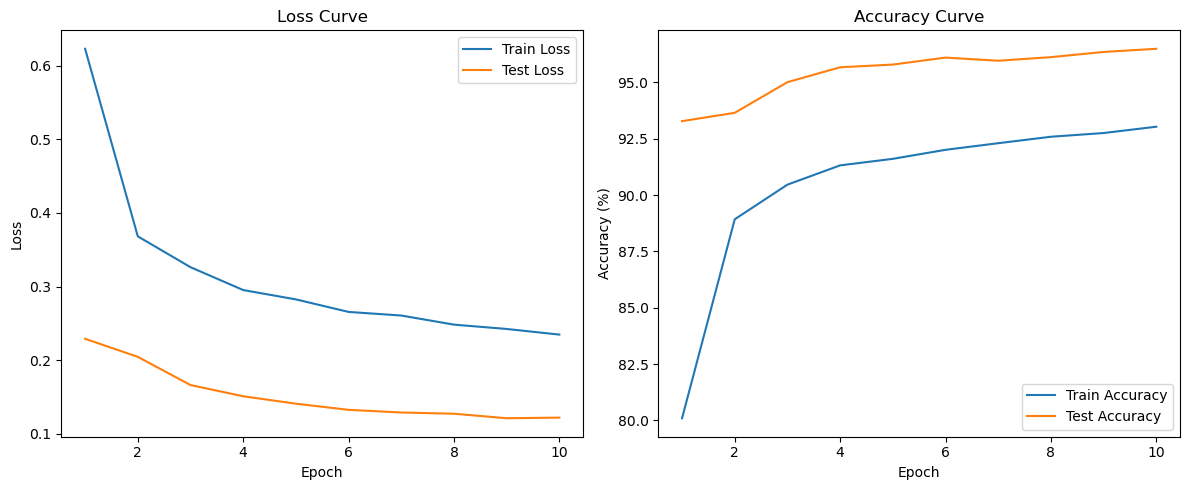

In [160]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")

# 1. 数据加载与预处理

# 定义数据预处理步骤
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 对MNIST数据进行标准化
])

# 下载并加载训练数据集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# 下载并加载测试数据集
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
testloader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

# 2. 模型定义

class SimpleNetWithDropout(nn.Module):
    def __init__(self):
        super(SimpleNetWithDropout, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout层，丢弃概率为0.5
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)  # 另一个Dropout层
        self.fc3 = nn.Linear(128, 10)  # 输出层，10个类别

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# 实例化模型并移动到设备
model = SimpleNetWithDropout().to(device)
print(model)

# 3. 定义损失函数和优化器

criterion = nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 4. 训练与评估函数

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # 将数据移动到设备
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 梯度归零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计损失
        running_loss += loss.item() * inputs.size(0)
        
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    print(f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

def evaluate(model, device, test_loader, criterion):
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # 禁用梯度计算
        for inputs, targets in test_loader:
            # 将数据移动到设备
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 统计损失
            running_loss += loss.item() * inputs.size(0)
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

# 5. 训练模型

num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch} ---")
    train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch)
    test_loss, test_acc = evaluate(model, device, testloader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# 6. 结果可视化

# 绘制训练和测试的损失曲线
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# 绘制训练和测试的准确率曲线
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

通过使用Dropout，训练数据和测试数据的识别精度的差距 变小了。并且，训练数据也没有到达100%的识别精度。像这样，通过使用 Dropout， 即便是表现力强的网络，也可以抑制过拟合。

| 方面            | Dropout（丢弃法）                                                  | 集成学习（Ensemble Learning）                         |
|-----------------|--------------------------------------------------------------------|-----------------------------------------------------|
| 实现方式        | 在训练过程中随机丢弃部分神经元，迫使网络学习不同的子网络。          | 训练多个独立的模型，然后将它们的预测结果进行组合。   |
| 计算成本        | 相对较低，只需训练一个模型。                                       | 相对较高，需要训练多个独立的模型。                   |
| 预测方式        | 在推理时使用所有神经元，并通过权重缩放保持输出的一致性。           | 在推理时结合多个模型的预测结果，如投票、平均等。     |
| 模型独立性      | 子网络共享权重，存在一定的依赖性。                                 | 各个模型独立训练，完全独立。                         |
| 效果            | 提供类似于集成学习的效果，减少过拟合，提高泛化能力。               | 通常能够显著提升模型性能，尤其在模型之间存在较大差异时效果更佳。 |
| 适用场景        | 深度神经网络，尤其是具有大量参数和层数的网络。                     | 各种机器学习模型，包括决策树、支持向量机、神经网络等。 |
| 灵活性          | 适用于单一模型，通过调整 Dropout 率控制正则化强度。                | 更加灵活，可以选择不同类型的模型进行组合，甚至结合不同的学习算法。 |
| 超参数          | Dropout 率（丢弃概率）。                                          | 每个模型的超参数组合，以及组合方法（如投票、平均等）。 |

## 超参数的验证

神经网络中，除了权重和偏置等参数，超参数（hyper-parameter）也经常出现。这里所说的超参数是指，比如各层的神经元数量、 batch大小、 参数更新时的学习率或权值衰减等。如果这些超参数没有设置合适的值，模型的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中一般会伴随很多的试错。本节将介绍尽可能高效地寻找超参数的值的方法。

下面我们要对超参数设置各种各样的值以进行验证。这里要注意的是，不能使用测试数据评估超参数的性能。这一点非常重要，但也容易被忽视。

为什么不能用测试数据评估超参数的性能呢？这是因为如果使用测试数 据调整超参数，超参数的值会对测试数据发生过拟合。换句话说，用测试数据确认超参数的值的“好坏”，就会导致超参数的值被调整为只拟合测试数据。 这样的话，可能就会得到不能拟合其他数据、泛化能力低的模型。

因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为验证数据（validation data） 。我们使用这个验证数据来评估超参数的好坏。

训练数据用于参数（权重和偏置）的学习，验证数据用于超参数的性能评估。为了确认泛化能力，要在最后使用（比较理想的是只用一次）测试数据。

* 训练集（Training Set）：用于模型参数的学习，即在训练过程中用来调整模型内部权重的样本数据。
* 验证集（Validation Set）：用于超参数调整和模型选择，即在训练过程中用来评估不同超参数设置下模型性能的数据。验证集不会用于权重更新。
* 测试集（Test Set）：用于在最终确定模型后评估其泛化性能，模拟模型在实际未见过数据上的表现。

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 定义一个简单的神经网络模型
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.fc(x)

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 下载并加载训练数据集
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 划分训练集和验证集，例如 80% 训练，20% 验证
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# 创建训练集和验证集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 加载测试数据集
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义不同学习率的超参数候选
learning_rates = [0.001, 0.01, 0.1]
best_lr = None
best_val_acc = 0.0

for lr in learning_rates:
    model = SimpleNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 在训练集上训练一个 epoch
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # 在验证集上评估模型性能
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    val_acc = correct / total
    print(f"学习率: {lr}, 验证集准确率: {val_acc*100:.2f}%")
    
    # 保存最佳学习率
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr

print(f"\n最佳学习率: {best_lr}, 对应验证集准确率: {best_val_acc*100:.2f}%")

# 使用最佳学习率在训练集和验证集上重新训练模型，并在测试集上进行最终评估
# 合并训练集和验证集用于最终训练
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

# 初始化模型并使用最佳学习率进行训练
final_model = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_lr)

# 在合并后的数据集上训练若干个 epoch，这里简单训练 5 个 epoch 作为示例
num_epochs = 5
for epoch in range(num_epochs):
    final_model.train()
    for inputs, targets in combined_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} 完成")

# 在测试集上评估最终模型
final_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_acc = correct / total
print(f"\n最终模型在测试集上的准确率: {test_acc*100:.2f}%")

学习率: 0.001, 验证集准确率: 89.08%
学习率: 0.01, 验证集准确率: 87.55%
学习率: 0.1, 验证集准确率: 88.31%

最佳学习率: 0.001, 对应验证集准确率: 89.08%
Epoch 1 完成
Epoch 2 完成
Epoch 3 完成
Epoch 4 完成
Epoch 5 完成

最终模型在测试集上的准确率: 91.82%


* 训练集（Training Set）和验证集（Validation Set）：我们从MNIST的训练数据（train=True部分）中划分出训练集和验证集。划分比例通常为 80% 训练、20% 验证。这两部分数据用于模型的训练和超参数调优。

* 测试集（Test Set）：测试集是从 MNIST 的测试数据（train=False 部分）独立获得的。这个数据集在整个训练和验证过程中都未被使用，仅在最终评估模型时使用，以测试模型的泛化性能。